In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

In [2]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
shap.initjs()

In [4]:
data = pd.read_parquet('/main/data/MVideo_2/dataset_main_7_m_4.parquet')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719968 entries, 0 to 1719967
Columns: 125 entries, STORE_ID to UNITS_SOLD_P4
dtypes: category(8), datetime64[ns](1), float32(87), int32(29)
memory usage: 803.8 MB


In [6]:
data_train = data[data.DATE < '2018-02-25']

In [7]:
data_train.shape[0]

1026469

In [8]:
data_train2 = data[data.DATE <= '2018-03-18']

In [9]:
data_train2.shape[0]

1163328

In [10]:
data_val = data[(data.DATE >= '2018-02-25') & (data.DATE <= '2018-03-18')]

In [11]:
data_val.shape[0]

136859

In [12]:
data_test = data[data.DATE == '2018-07-08']

In [13]:
data_test.shape[0]

34790

In [14]:
feat = [s for s in data.columns if s not in ['DATE', 'UNITS_SOLD_P4']]

In [15]:
dts = lgb.Dataset(data_train[feat], label = data_train.UNITS_SOLD_P4)

In [16]:
dts = dts.construct()

In [17]:
dtsv = dts.create_valid(data_val[feat], label = data_val.UNITS_SOLD_P4)

In [18]:
space = {
        'num_leaves': hp.quniform('num_leaves', 3, 9, 1),
        'min_data_in_leaf':hp.quniform('min_data_in_leaf', 10, 1000, 10),
        'min_sum_hessian_in_leaf': hp.quniform('min_sum_hessian_in_leaf', -5, 2, 1),
        'feature_fraction': hp.quniform('feature_fraction', 0.5, 1, 0.1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.5, 1, 0.1),
        'bagging_freq': hp.quniform('bagging_freq', 0, 10, 1),
        'lambda_l2': hp.loguniform('lambda_l2', -9, 3),
       }

In [19]:
def get_params(space):
    params = dict()
    params['application'] = 'regression_l2'
    params['learning_rate'] = 0.03
    params['num_leaves'] = 2 ** int(space['num_leaves']) - 1
    params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    params['min_sum_hessian_in_leaf'] = 10 ** int(space['min_sum_hessian_in_leaf'])
    params['feature_fraction'] = np.round(space['feature_fraction'], 1)
    params['bagging_fraction'] = np.round(space['bagging_fraction'], 1)
    params['bagging_freq'] = int(space['bagging_freq'])
    params['lambda_l2'] = np.round(space['lambda_l2'], 4)
    params['metric'] = 'l2_root'
    return params

In [20]:
def objective_reg(space):
    params = get_params(space)
    bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'], num_boost_round = 10000,
                    early_stopping_rounds = 20)
    pred = bst.predict(data_val[feat])
    test_loss = mean_squared_error(data_val.UNITS_SOLD_P4, pred) ** 0.5
    return{'loss': test_loss, 'status': STATUS_OK, 'attachments': params}

In [21]:
N_HYPEROPT_PROBES = 30
HYPEROPT_ALGO = tpe.suggest #hyperopt.rand.suggest

trials = Trials()
best = fmin(fn=objective_reg,
            space=space,
            algo=HYPEROPT_ALGO,
            max_evals=N_HYPEROPT_PROBES,
            trials=trials,
            verbose=1)

[1]	Validation's rmse: 1.9701
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.95229
[3]	Validation's rmse: 1.93012
[4]	Validation's rmse: 1.90582
[5]	Validation's rmse: 1.88439
[6]	Validation's rmse: 1.86601
[7]	Validation's rmse: 1.84558
[8]	Validation's rmse: 1.82653
[9]	Validation's rmse: 1.80711
[10]	Validation's rmse: 1.7929
[11]	Validation's rmse: 1.77473
[12]	Validation's rmse: 1.75814
[13]	Validation's rmse: 1.74605
[14]	Validation's rmse: 1.72916
[15]	Validation's rmse: 1.71573
[16]	Validation's rmse: 1.70745
[17]	Validation's rmse: 1.69524
[18]	Validation's rmse: 1.68391
[19]	Validation's rmse: 1.67172
[20]	Validation's rmse: 1.66082
[21]	Validation's rmse: 1.64718
[22]	Validation's rmse: 1.63425
[23]	Validation's rmse: 1.62385
[24]	Validation's rmse: 1.61667
[25]	Validation's rmse: 1.60744
[26]	Validation's rmse: 1.59898
[27]	Validation's rmse: 1.59138
[28]	Validation's rmse: 1.58239
[29]	Validation's rmse: 1.57333
[30]	Validation's rms

[255]	Validation's rmse: 1.38682
[256]	Validation's rmse: 1.38648
[257]	Validation's rmse: 1.38628
[258]	Validation's rmse: 1.38638
[259]	Validation's rmse: 1.38614
[260]	Validation's rmse: 1.38578
[261]	Validation's rmse: 1.38569
[262]	Validation's rmse: 1.38556
[263]	Validation's rmse: 1.38531
[264]	Validation's rmse: 1.38525
[265]	Validation's rmse: 1.38522
[266]	Validation's rmse: 1.38516
[267]	Validation's rmse: 1.38505
[268]	Validation's rmse: 1.3851
[269]	Validation's rmse: 1.38503
[270]	Validation's rmse: 1.38497
[271]	Validation's rmse: 1.38489
[272]	Validation's rmse: 1.38489
[273]	Validation's rmse: 1.38478
[274]	Validation's rmse: 1.38475
[275]	Validation's rmse: 1.38468
[276]	Validation's rmse: 1.38467
[277]	Validation's rmse: 1.38464
[278]	Validation's rmse: 1.3845
[279]	Validation's rmse: 1.38438
[280]	Validation's rmse: 1.38433
[281]	Validation's rmse: 1.38451
[282]	Validation's rmse: 1.38443
[283]	Validation's rmse: 1.38448
[284]	Validation's rmse: 1.38442
[285]	Valida

[508]	Validation's rmse: 1.37292
[509]	Validation's rmse: 1.37285
[510]	Validation's rmse: 1.37283
[511]	Validation's rmse: 1.37289
[512]	Validation's rmse: 1.37293
[513]	Validation's rmse: 1.37293
[514]	Validation's rmse: 1.37297
[515]	Validation's rmse: 1.37293
[516]	Validation's rmse: 1.37291
[517]	Validation's rmse: 1.37301
[518]	Validation's rmse: 1.37282
[519]	Validation's rmse: 1.37279
[520]	Validation's rmse: 1.37281
[521]	Validation's rmse: 1.37284
[522]	Validation's rmse: 1.37272
[523]	Validation's rmse: 1.37274
[524]	Validation's rmse: 1.37279
[525]	Validation's rmse: 1.37286
[526]	Validation's rmse: 1.37272
[527]	Validation's rmse: 1.37258
[528]	Validation's rmse: 1.37247
[529]	Validation's rmse: 1.37252
[530]	Validation's rmse: 1.37253
[531]	Validation's rmse: 1.37248
[532]	Validation's rmse: 1.3727
[533]	Validation's rmse: 1.37282
[534]	Validation's rmse: 1.37294
[535]	Validation's rmse: 1.37286
[536]	Validation's rmse: 1.37284
[537]	Validation's rmse: 1.37275
[538]	Valid

[73]	Validation's rmse: 1.40957
[74]	Validation's rmse: 1.40837
[75]	Validation's rmse: 1.40754
[76]	Validation's rmse: 1.40714
[77]	Validation's rmse: 1.406
[78]	Validation's rmse: 1.40534
[79]	Validation's rmse: 1.40463
[80]	Validation's rmse: 1.40416
[81]	Validation's rmse: 1.40307
[82]	Validation's rmse: 1.40262
[83]	Validation's rmse: 1.40206
[84]	Validation's rmse: 1.40208
[85]	Validation's rmse: 1.4015
[86]	Validation's rmse: 1.40108
[87]	Validation's rmse: 1.40076
[88]	Validation's rmse: 1.40037
[89]	Validation's rmse: 1.39972
[90]	Validation's rmse: 1.39907
[91]	Validation's rmse: 1.39836
[92]	Validation's rmse: 1.39828
[93]	Validation's rmse: 1.39767
[94]	Validation's rmse: 1.39729
[95]	Validation's rmse: 1.39677
[96]	Validation's rmse: 1.39664
[97]	Validation's rmse: 1.39611
[98]	Validation's rmse: 1.39579
[99]	Validation's rmse: 1.39539
[100]	Validation's rmse: 1.39493
[101]	Validation's rmse: 1.39454
[102]	Validation's rmse: 1.39404
[103]	Validation's rmse: 1.39362
[104]	V

[325]	Validation's rmse: 1.3625
[326]	Validation's rmse: 1.36248
[327]	Validation's rmse: 1.36239
[328]	Validation's rmse: 1.36228
[329]	Validation's rmse: 1.36231
[330]	Validation's rmse: 1.36236
[331]	Validation's rmse: 1.36227
[332]	Validation's rmse: 1.36212
[333]	Validation's rmse: 1.36202
[334]	Validation's rmse: 1.36195
[335]	Validation's rmse: 1.3618
[336]	Validation's rmse: 1.36173
[337]	Validation's rmse: 1.36159
[338]	Validation's rmse: 1.36163
[339]	Validation's rmse: 1.36162
[340]	Validation's rmse: 1.36157
[341]	Validation's rmse: 1.36154
[342]	Validation's rmse: 1.36154
[343]	Validation's rmse: 1.3614
[344]	Validation's rmse: 1.36143
[345]	Validation's rmse: 1.36133
[346]	Validation's rmse: 1.36121
[347]	Validation's rmse: 1.36117
[348]	Validation's rmse: 1.36123
[349]	Validation's rmse: 1.36126
[350]	Validation's rmse: 1.36131
[351]	Validation's rmse: 1.36135
[352]	Validation's rmse: 1.3613
[353]	Validation's rmse: 1.36117
[354]	Validation's rmse: 1.36098
[355]	Validati

[574]	Validation's rmse: 1.35643
[575]	Validation's rmse: 1.35644
[576]	Validation's rmse: 1.35651
[577]	Validation's rmse: 1.35644
[578]	Validation's rmse: 1.35635
[579]	Validation's rmse: 1.3564
[580]	Validation's rmse: 1.35642
[581]	Validation's rmse: 1.35637
[582]	Validation's rmse: 1.35631
[583]	Validation's rmse: 1.35619
[584]	Validation's rmse: 1.35617
[585]	Validation's rmse: 1.35611
[586]	Validation's rmse: 1.35611
[587]	Validation's rmse: 1.35615
[588]	Validation's rmse: 1.35622
[589]	Validation's rmse: 1.3562
[590]	Validation's rmse: 1.35607
[591]	Validation's rmse: 1.35613
[592]	Validation's rmse: 1.35612
[593]	Validation's rmse: 1.35611
[594]	Validation's rmse: 1.35607
[595]	Validation's rmse: 1.35609
[596]	Validation's rmse: 1.35606
[597]	Validation's rmse: 1.356
[598]	Validation's rmse: 1.35595
[599]	Validation's rmse: 1.35594
[600]	Validation's rmse: 1.35586
[601]	Validation's rmse: 1.35584
[602]	Validation's rmse: 1.35583
[603]	Validation's rmse: 1.35584
[604]	Validati

[197]	Validation's rmse: 1.4595
[198]	Validation's rmse: 1.45936
[199]	Validation's rmse: 1.45926
[200]	Validation's rmse: 1.45887
[201]	Validation's rmse: 1.45879
[202]	Validation's rmse: 1.45784
[203]	Validation's rmse: 1.45724
[204]	Validation's rmse: 1.45639
[205]	Validation's rmse: 1.45622
[206]	Validation's rmse: 1.45588
[207]	Validation's rmse: 1.45562
[208]	Validation's rmse: 1.45514
[209]	Validation's rmse: 1.45475
[210]	Validation's rmse: 1.45454
[211]	Validation's rmse: 1.45427
[212]	Validation's rmse: 1.45432
[213]	Validation's rmse: 1.45385
[214]	Validation's rmse: 1.45377
[215]	Validation's rmse: 1.45361
[216]	Validation's rmse: 1.45341
[217]	Validation's rmse: 1.45306
[218]	Validation's rmse: 1.45301
[219]	Validation's rmse: 1.45291
[220]	Validation's rmse: 1.45284
[221]	Validation's rmse: 1.45266
[222]	Validation's rmse: 1.45242
[223]	Validation's rmse: 1.45186
[224]	Validation's rmse: 1.4518
[225]	Validation's rmse: 1.45174
[226]	Validation's rmse: 1.45144
[227]	Valida

[448]	Validation's rmse: 1.43093
[449]	Validation's rmse: 1.43072
[450]	Validation's rmse: 1.4307
[451]	Validation's rmse: 1.43073
[452]	Validation's rmse: 1.43064
[453]	Validation's rmse: 1.43066
[454]	Validation's rmse: 1.43049
[455]	Validation's rmse: 1.43046
[456]	Validation's rmse: 1.43038
[457]	Validation's rmse: 1.4304
[458]	Validation's rmse: 1.43049
[459]	Validation's rmse: 1.43031
[460]	Validation's rmse: 1.43024
[461]	Validation's rmse: 1.43023
[462]	Validation's rmse: 1.43009
[463]	Validation's rmse: 1.43002
[464]	Validation's rmse: 1.42993
[465]	Validation's rmse: 1.43
[466]	Validation's rmse: 1.4304
[467]	Validation's rmse: 1.43033
[468]	Validation's rmse: 1.43027
[469]	Validation's rmse: 1.43016
[470]	Validation's rmse: 1.43012
[471]	Validation's rmse: 1.4301
[472]	Validation's rmse: 1.43005
[473]	Validation's rmse: 1.42989
[474]	Validation's rmse: 1.42988
[475]	Validation's rmse: 1.42991
[476]	Validation's rmse: 1.42987
[477]	Validation's rmse: 1.42985
[478]	Validation'

[707]	Validation's rmse: 1.42144
[708]	Validation's rmse: 1.42144
[709]	Validation's rmse: 1.4215
[710]	Validation's rmse: 1.4214
[711]	Validation's rmse: 1.42136
[712]	Validation's rmse: 1.42122
[713]	Validation's rmse: 1.42125
[714]	Validation's rmse: 1.42124
[715]	Validation's rmse: 1.42124
[716]	Validation's rmse: 1.42117
[717]	Validation's rmse: 1.42136
[718]	Validation's rmse: 1.42142
[719]	Validation's rmse: 1.4213
[720]	Validation's rmse: 1.42125
[721]	Validation's rmse: 1.42102
[722]	Validation's rmse: 1.42094
[723]	Validation's rmse: 1.42091
[724]	Validation's rmse: 1.42091
[725]	Validation's rmse: 1.42083
[726]	Validation's rmse: 1.42085
[727]	Validation's rmse: 1.42086
[728]	Validation's rmse: 1.42079
[729]	Validation's rmse: 1.42096
[730]	Validation's rmse: 1.42095
[731]	Validation's rmse: 1.42097
[732]	Validation's rmse: 1.42094
[733]	Validation's rmse: 1.42088
[734]	Validation's rmse: 1.42087
[735]	Validation's rmse: 1.42079
[736]	Validation's rmse: 1.42077
[737]	Validat

[962]	Validation's rmse: 1.4149
[963]	Validation's rmse: 1.41472
[964]	Validation's rmse: 1.41483
[965]	Validation's rmse: 1.41478
[966]	Validation's rmse: 1.41476
[967]	Validation's rmse: 1.4148
[968]	Validation's rmse: 1.41485
[969]	Validation's rmse: 1.41489
[970]	Validation's rmse: 1.41485
[971]	Validation's rmse: 1.415
[972]	Validation's rmse: 1.41483
[973]	Validation's rmse: 1.41483
[974]	Validation's rmse: 1.41482
[975]	Validation's rmse: 1.41474
[976]	Validation's rmse: 1.4147
[977]	Validation's rmse: 1.41468
[978]	Validation's rmse: 1.41466
[979]	Validation's rmse: 1.41466
[980]	Validation's rmse: 1.41467
[981]	Validation's rmse: 1.41468
[982]	Validation's rmse: 1.4147
[983]	Validation's rmse: 1.41465
[984]	Validation's rmse: 1.41464
[985]	Validation's rmse: 1.4146
[986]	Validation's rmse: 1.41463
[987]	Validation's rmse: 1.41465
[988]	Validation's rmse: 1.41456
[989]	Validation's rmse: 1.41454
[990]	Validation's rmse: 1.41459
[991]	Validation's rmse: 1.41458
[992]	Validation'

[1206]	Validation's rmse: 1.40932
[1207]	Validation's rmse: 1.40937
[1208]	Validation's rmse: 1.40935
[1209]	Validation's rmse: 1.40933
[1210]	Validation's rmse: 1.40934
[1211]	Validation's rmse: 1.40932
[1212]	Validation's rmse: 1.40931
[1213]	Validation's rmse: 1.40931
[1214]	Validation's rmse: 1.40927
[1215]	Validation's rmse: 1.40925
[1216]	Validation's rmse: 1.40921
[1217]	Validation's rmse: 1.40922
[1218]	Validation's rmse: 1.40912
[1219]	Validation's rmse: 1.40904
[1220]	Validation's rmse: 1.40897
[1221]	Validation's rmse: 1.40899
[1222]	Validation's rmse: 1.40899
[1223]	Validation's rmse: 1.40898
[1224]	Validation's rmse: 1.40898
[1225]	Validation's rmse: 1.40893
[1226]	Validation's rmse: 1.40898
[1227]	Validation's rmse: 1.40905
[1228]	Validation's rmse: 1.40903
[1229]	Validation's rmse: 1.40909
[1230]	Validation's rmse: 1.409
[1231]	Validation's rmse: 1.40891
[1232]	Validation's rmse: 1.40891
[1233]	Validation's rmse: 1.40893
[1234]	Validation's rmse: 1.4089
[1235]	Validation

[1459]	Validation's rmse: 1.40456
[1460]	Validation's rmse: 1.4046
[1461]	Validation's rmse: 1.40462
[1462]	Validation's rmse: 1.40456
[1463]	Validation's rmse: 1.40457
[1464]	Validation's rmse: 1.40466
[1465]	Validation's rmse: 1.40456
[1466]	Validation's rmse: 1.40458
[1467]	Validation's rmse: 1.40459
[1468]	Validation's rmse: 1.40459
[1469]	Validation's rmse: 1.40456
[1470]	Validation's rmse: 1.40442
[1471]	Validation's rmse: 1.40444
[1472]	Validation's rmse: 1.40438
[1473]	Validation's rmse: 1.40438
[1474]	Validation's rmse: 1.40437
[1475]	Validation's rmse: 1.40441
[1476]	Validation's rmse: 1.40436
[1477]	Validation's rmse: 1.40432
[1478]	Validation's rmse: 1.40428
[1479]	Validation's rmse: 1.40425
[1480]	Validation's rmse: 1.40421
[1481]	Validation's rmse: 1.40418
[1482]	Validation's rmse: 1.40417
[1483]	Validation's rmse: 1.40411
[1484]	Validation's rmse: 1.40412
[1485]	Validation's rmse: 1.40414
[1486]	Validation's rmse: 1.40414
[1487]	Validation's rmse: 1.40398
[1488]	Validati

[80]	Validation's rmse: 1.42375
[81]	Validation's rmse: 1.4228
[82]	Validation's rmse: 1.42217
[83]	Validation's rmse: 1.42075
[84]	Validation's rmse: 1.41968
[85]	Validation's rmse: 1.41828
[86]	Validation's rmse: 1.41734
[87]	Validation's rmse: 1.41657
[88]	Validation's rmse: 1.41556
[89]	Validation's rmse: 1.41475
[90]	Validation's rmse: 1.41393
[91]	Validation's rmse: 1.41294
[92]	Validation's rmse: 1.41225
[93]	Validation's rmse: 1.41154
[94]	Validation's rmse: 1.41055
[95]	Validation's rmse: 1.41026
[96]	Validation's rmse: 1.4097
[97]	Validation's rmse: 1.40949
[98]	Validation's rmse: 1.40906
[99]	Validation's rmse: 1.40821
[100]	Validation's rmse: 1.40755
[101]	Validation's rmse: 1.40696
[102]	Validation's rmse: 1.40685
[103]	Validation's rmse: 1.40634
[104]	Validation's rmse: 1.40577
[105]	Validation's rmse: 1.40498
[106]	Validation's rmse: 1.40452
[107]	Validation's rmse: 1.40418
[108]	Validation's rmse: 1.40383
[109]	Validation's rmse: 1.40299
[110]	Validation's rmse: 1.40266

[334]	Validation's rmse: 1.37371
[335]	Validation's rmse: 1.37383
[336]	Validation's rmse: 1.37383
[337]	Validation's rmse: 1.37381
[338]	Validation's rmse: 1.37379
[339]	Validation's rmse: 1.37368
[340]	Validation's rmse: 1.37361
[341]	Validation's rmse: 1.37351
[342]	Validation's rmse: 1.37357
[343]	Validation's rmse: 1.37353
[344]	Validation's rmse: 1.37354
[345]	Validation's rmse: 1.37349
[346]	Validation's rmse: 1.37343
[347]	Validation's rmse: 1.3735
[348]	Validation's rmse: 1.37356
[349]	Validation's rmse: 1.37351
[350]	Validation's rmse: 1.37351
[351]	Validation's rmse: 1.37339
[352]	Validation's rmse: 1.37354
[353]	Validation's rmse: 1.37339
[354]	Validation's rmse: 1.37327
[355]	Validation's rmse: 1.3733
[356]	Validation's rmse: 1.37327
[357]	Validation's rmse: 1.37328
[358]	Validation's rmse: 1.37302
[359]	Validation's rmse: 1.37293
[360]	Validation's rmse: 1.37298
[361]	Validation's rmse: 1.37303
[362]	Validation's rmse: 1.37305
[363]	Validation's rmse: 1.37295
[364]	Valida

[588]	Validation's rmse: 1.36484
[589]	Validation's rmse: 1.36487
[590]	Validation's rmse: 1.3642
[591]	Validation's rmse: 1.36419
[592]	Validation's rmse: 1.36417
[593]	Validation's rmse: 1.36396
[594]	Validation's rmse: 1.36343
[595]	Validation's rmse: 1.36342
[596]	Validation's rmse: 1.36342
[597]	Validation's rmse: 1.3633
[598]	Validation's rmse: 1.36325
[599]	Validation's rmse: 1.36324
[600]	Validation's rmse: 1.36324
[601]	Validation's rmse: 1.3632
[602]	Validation's rmse: 1.36321
[603]	Validation's rmse: 1.36321
[604]	Validation's rmse: 1.36316
[605]	Validation's rmse: 1.36317
[606]	Validation's rmse: 1.36315
[607]	Validation's rmse: 1.36321
[608]	Validation's rmse: 1.36322
[609]	Validation's rmse: 1.36304
[610]	Validation's rmse: 1.36297
[611]	Validation's rmse: 1.36292
[612]	Validation's rmse: 1.36292
[613]	Validation's rmse: 1.36263
[614]	Validation's rmse: 1.36257
[615]	Validation's rmse: 1.36239
[616]	Validation's rmse: 1.36236
[617]	Validation's rmse: 1.36241
[618]	Validat

[16]	Validation's rmse: 1.68562
[17]	Validation's rmse: 1.67453
[18]	Validation's rmse: 1.66244
[19]	Validation's rmse: 1.64977
[20]	Validation's rmse: 1.64033
[21]	Validation's rmse: 1.62878
[22]	Validation's rmse: 1.61646
[23]	Validation's rmse: 1.60651
[24]	Validation's rmse: 1.59904
[25]	Validation's rmse: 1.58902
[26]	Validation's rmse: 1.58217
[27]	Validation's rmse: 1.57293
[28]	Validation's rmse: 1.56561
[29]	Validation's rmse: 1.55722
[30]	Validation's rmse: 1.54937
[31]	Validation's rmse: 1.54323
[32]	Validation's rmse: 1.53724
[33]	Validation's rmse: 1.53084
[34]	Validation's rmse: 1.52552
[35]	Validation's rmse: 1.51974
[36]	Validation's rmse: 1.51438
[37]	Validation's rmse: 1.50958
[38]	Validation's rmse: 1.50442
[39]	Validation's rmse: 1.50026
[40]	Validation's rmse: 1.49609
[41]	Validation's rmse: 1.4917
[42]	Validation's rmse: 1.48792
[43]	Validation's rmse: 1.48366
[44]	Validation's rmse: 1.47957
[45]	Validation's rmse: 1.47601
[46]	Validation's rmse: 1.47271
[47]	Vali

[269]	Validation's rmse: 1.37578
[270]	Validation's rmse: 1.37576
[271]	Validation's rmse: 1.37563
[272]	Validation's rmse: 1.37556
[273]	Validation's rmse: 1.37557
[274]	Validation's rmse: 1.37548
[275]	Validation's rmse: 1.37541
[276]	Validation's rmse: 1.37533
[277]	Validation's rmse: 1.37529
[278]	Validation's rmse: 1.37522
[279]	Validation's rmse: 1.37516
[280]	Validation's rmse: 1.37503
[281]	Validation's rmse: 1.37498
[282]	Validation's rmse: 1.37487
[283]	Validation's rmse: 1.37479
[284]	Validation's rmse: 1.37482
[285]	Validation's rmse: 1.37468
[286]	Validation's rmse: 1.3747
[287]	Validation's rmse: 1.37476
[288]	Validation's rmse: 1.37475
[289]	Validation's rmse: 1.37476
[290]	Validation's rmse: 1.37478
[291]	Validation's rmse: 1.37469
[292]	Validation's rmse: 1.37468
[293]	Validation's rmse: 1.3746
[294]	Validation's rmse: 1.37453
[295]	Validation's rmse: 1.37455
[296]	Validation's rmse: 1.37452
[297]	Validation's rmse: 1.37444
[298]	Validation's rmse: 1.37438
[299]	Valida

[519]	Validation's rmse: 1.36663
[520]	Validation's rmse: 1.3666
[521]	Validation's rmse: 1.36646
[522]	Validation's rmse: 1.36641
[523]	Validation's rmse: 1.36639
[524]	Validation's rmse: 1.36629
[525]	Validation's rmse: 1.36626
[526]	Validation's rmse: 1.3663
[527]	Validation's rmse: 1.36633
[528]	Validation's rmse: 1.36626
[529]	Validation's rmse: 1.36624
[530]	Validation's rmse: 1.36609
[531]	Validation's rmse: 1.36591
[532]	Validation's rmse: 1.36586
[533]	Validation's rmse: 1.36594
[534]	Validation's rmse: 1.366
[535]	Validation's rmse: 1.36595
[536]	Validation's rmse: 1.3659
[537]	Validation's rmse: 1.36593
[538]	Validation's rmse: 1.36589
[539]	Validation's rmse: 1.36584
[540]	Validation's rmse: 1.36578
[541]	Validation's rmse: 1.3658
[542]	Validation's rmse: 1.36576
[543]	Validation's rmse: 1.36565
[544]	Validation's rmse: 1.36567
[545]	Validation's rmse: 1.36559
[546]	Validation's rmse: 1.36568
[547]	Validation's rmse: 1.36574
[548]	Validation's rmse: 1.36575
[549]	Validation

[209]	Validation's rmse: 1.38764
[210]	Validation's rmse: 1.38746
[211]	Validation's rmse: 1.38736
[212]	Validation's rmse: 1.38739
[213]	Validation's rmse: 1.38712
[214]	Validation's rmse: 1.38693
[215]	Validation's rmse: 1.38671
[216]	Validation's rmse: 1.3867
[217]	Validation's rmse: 1.38631
[218]	Validation's rmse: 1.38619
[219]	Validation's rmse: 1.38646
[220]	Validation's rmse: 1.38625
[221]	Validation's rmse: 1.38608
[222]	Validation's rmse: 1.38597
[223]	Validation's rmse: 1.38591
[224]	Validation's rmse: 1.38574
[225]	Validation's rmse: 1.38565
[226]	Validation's rmse: 1.38554
[227]	Validation's rmse: 1.3855
[228]	Validation's rmse: 1.38533
[229]	Validation's rmse: 1.38527
[230]	Validation's rmse: 1.38528
[231]	Validation's rmse: 1.38517
[232]	Validation's rmse: 1.38508
[233]	Validation's rmse: 1.38501
[234]	Validation's rmse: 1.38506
[235]	Validation's rmse: 1.38507
[236]	Validation's rmse: 1.38483
[237]	Validation's rmse: 1.38469
[238]	Validation's rmse: 1.38484
[239]	Valida

[170]	Validation's rmse: 1.40008
[171]	Validation's rmse: 1.40023
[172]	Validation's rmse: 1.39993
[173]	Validation's rmse: 1.39968
[174]	Validation's rmse: 1.39962
[175]	Validation's rmse: 1.39926
[176]	Validation's rmse: 1.39906
[177]	Validation's rmse: 1.39893
[178]	Validation's rmse: 1.39893
[179]	Validation's rmse: 1.3989
[180]	Validation's rmse: 1.3989
[181]	Validation's rmse: 1.39882
[182]	Validation's rmse: 1.39886
[183]	Validation's rmse: 1.39862
[184]	Validation's rmse: 1.39853
[185]	Validation's rmse: 1.39849
[186]	Validation's rmse: 1.39837
[187]	Validation's rmse: 1.39846
[188]	Validation's rmse: 1.39832
[189]	Validation's rmse: 1.39834
[190]	Validation's rmse: 1.398
[191]	Validation's rmse: 1.39791
[192]	Validation's rmse: 1.39777
[193]	Validation's rmse: 1.39776
[194]	Validation's rmse: 1.39767
[195]	Validation's rmse: 1.39756
[196]	Validation's rmse: 1.39746
[197]	Validation's rmse: 1.39719
[198]	Validation's rmse: 1.39711
[199]	Validation's rmse: 1.39703
[200]	Validati

[425]	Validation's rmse: 1.38114
[426]	Validation's rmse: 1.38106
[427]	Validation's rmse: 1.38111
[428]	Validation's rmse: 1.38102
[429]	Validation's rmse: 1.38093
[430]	Validation's rmse: 1.38086
[431]	Validation's rmse: 1.38074
[432]	Validation's rmse: 1.3807
[433]	Validation's rmse: 1.38057
[434]	Validation's rmse: 1.38051
[435]	Validation's rmse: 1.38047
[436]	Validation's rmse: 1.38045
[437]	Validation's rmse: 1.38045
[438]	Validation's rmse: 1.38038
[439]	Validation's rmse: 1.38037
[440]	Validation's rmse: 1.38029
[441]	Validation's rmse: 1.38032
[442]	Validation's rmse: 1.38033
[443]	Validation's rmse: 1.38025
[444]	Validation's rmse: 1.38018
[445]	Validation's rmse: 1.38017
[446]	Validation's rmse: 1.38007
[447]	Validation's rmse: 1.38004
[448]	Validation's rmse: 1.37997
[449]	Validation's rmse: 1.37998
[450]	Validation's rmse: 1.37995
[451]	Validation's rmse: 1.37992
[452]	Validation's rmse: 1.37996
[453]	Validation's rmse: 1.37995
[454]	Validation's rmse: 1.37984
[455]	Valid

[675]	Validation's rmse: 1.37389
[676]	Validation's rmse: 1.37384
[677]	Validation's rmse: 1.37382
[678]	Validation's rmse: 1.37377
[679]	Validation's rmse: 1.37369
[680]	Validation's rmse: 1.37363
[681]	Validation's rmse: 1.37363
[682]	Validation's rmse: 1.37357
[683]	Validation's rmse: 1.37361
[684]	Validation's rmse: 1.3736
[685]	Validation's rmse: 1.3736
[686]	Validation's rmse: 1.37361
[687]	Validation's rmse: 1.37367
[688]	Validation's rmse: 1.37371
[689]	Validation's rmse: 1.37374
[690]	Validation's rmse: 1.37372
[691]	Validation's rmse: 1.37363
[692]	Validation's rmse: 1.37363
[693]	Validation's rmse: 1.37366
[694]	Validation's rmse: 1.37364
[695]	Validation's rmse: 1.3737
[696]	Validation's rmse: 1.37364
[697]	Validation's rmse: 1.37366
[698]	Validation's rmse: 1.37371
[699]	Validation's rmse: 1.37365
[700]	Validation's rmse: 1.37361
[701]	Validation's rmse: 1.37357
[702]	Validation's rmse: 1.37355
[703]	Validation's rmse: 1.37358
[704]	Validation's rmse: 1.37354
[705]	Validat

[931]	Validation's rmse: 1.36876
[932]	Validation's rmse: 1.36879
[933]	Validation's rmse: 1.36883
[934]	Validation's rmse: 1.36883
[935]	Validation's rmse: 1.36879
[936]	Validation's rmse: 1.36877
[937]	Validation's rmse: 1.36878
[938]	Validation's rmse: 1.36877
[939]	Validation's rmse: 1.36872
[940]	Validation's rmse: 1.3687
[941]	Validation's rmse: 1.36868
[942]	Validation's rmse: 1.36871
[943]	Validation's rmse: 1.36869
[944]	Validation's rmse: 1.36864
[945]	Validation's rmse: 1.36869
[946]	Validation's rmse: 1.36866
[947]	Validation's rmse: 1.36867
[948]	Validation's rmse: 1.36868
[949]	Validation's rmse: 1.3687
[950]	Validation's rmse: 1.36864
[951]	Validation's rmse: 1.36865
[952]	Validation's rmse: 1.36862
[953]	Validation's rmse: 1.36859
[954]	Validation's rmse: 1.36844
[955]	Validation's rmse: 1.36846
[956]	Validation's rmse: 1.36839
[957]	Validation's rmse: 1.36838
[958]	Validation's rmse: 1.36837
[959]	Validation's rmse: 1.36831
[960]	Validation's rmse: 1.36829
[961]	Valida

[174]	Validation's rmse: 1.46916
[175]	Validation's rmse: 1.46865
[176]	Validation's rmse: 1.46821
[177]	Validation's rmse: 1.46788
[178]	Validation's rmse: 1.46744
[179]	Validation's rmse: 1.46725
[180]	Validation's rmse: 1.46707
[181]	Validation's rmse: 1.46679
[182]	Validation's rmse: 1.46633
[183]	Validation's rmse: 1.46633
[184]	Validation's rmse: 1.46624
[185]	Validation's rmse: 1.46618
[186]	Validation's rmse: 1.4656
[187]	Validation's rmse: 1.46461
[188]	Validation's rmse: 1.46454
[189]	Validation's rmse: 1.46451
[190]	Validation's rmse: 1.46418
[191]	Validation's rmse: 1.46361
[192]	Validation's rmse: 1.4635
[193]	Validation's rmse: 1.46344
[194]	Validation's rmse: 1.46325
[195]	Validation's rmse: 1.46308
[196]	Validation's rmse: 1.46286
[197]	Validation's rmse: 1.46273
[198]	Validation's rmse: 1.46172
[199]	Validation's rmse: 1.46137
[200]	Validation's rmse: 1.4612
[201]	Validation's rmse: 1.46103
[202]	Validation's rmse: 1.46059
[203]	Validation's rmse: 1.46046
[204]	Validat

[427]	Validation's rmse: 1.43535
[428]	Validation's rmse: 1.43535
[429]	Validation's rmse: 1.43528
[430]	Validation's rmse: 1.43527
[431]	Validation's rmse: 1.43527
[432]	Validation's rmse: 1.43528
[433]	Validation's rmse: 1.43524
[434]	Validation's rmse: 1.43524
[435]	Validation's rmse: 1.43528
[436]	Validation's rmse: 1.43529
[437]	Validation's rmse: 1.43528
[438]	Validation's rmse: 1.43522
[439]	Validation's rmse: 1.43514
[440]	Validation's rmse: 1.43514
[441]	Validation's rmse: 1.4351
[442]	Validation's rmse: 1.43506
[443]	Validation's rmse: 1.43504
[444]	Validation's rmse: 1.43509
[445]	Validation's rmse: 1.43476
[446]	Validation's rmse: 1.43475
[447]	Validation's rmse: 1.43463
[448]	Validation's rmse: 1.43439
[449]	Validation's rmse: 1.4343
[450]	Validation's rmse: 1.43426
[451]	Validation's rmse: 1.43423
[452]	Validation's rmse: 1.4343
[453]	Validation's rmse: 1.43418
[454]	Validation's rmse: 1.43417
[455]	Validation's rmse: 1.43414
[456]	Validation's rmse: 1.43408
[457]	Validat

[678]	Validation's rmse: 1.42427
[679]	Validation's rmse: 1.4243
[680]	Validation's rmse: 1.42431
[681]	Validation's rmse: 1.42435
[682]	Validation's rmse: 1.4242
[683]	Validation's rmse: 1.4242
[684]	Validation's rmse: 1.42412
[685]	Validation's rmse: 1.42411
[686]	Validation's rmse: 1.4241
[687]	Validation's rmse: 1.42408
[688]	Validation's rmse: 1.42407
[689]	Validation's rmse: 1.42413
[690]	Validation's rmse: 1.42416
[691]	Validation's rmse: 1.42408
[692]	Validation's rmse: 1.42396
[693]	Validation's rmse: 1.42379
[694]	Validation's rmse: 1.42371
[695]	Validation's rmse: 1.42369
[696]	Validation's rmse: 1.42358
[697]	Validation's rmse: 1.42355
[698]	Validation's rmse: 1.42343
[699]	Validation's rmse: 1.42344
[700]	Validation's rmse: 1.42314
[701]	Validation's rmse: 1.42318
[702]	Validation's rmse: 1.42318
[703]	Validation's rmse: 1.42312
[704]	Validation's rmse: 1.42312
[705]	Validation's rmse: 1.42309
[706]	Validation's rmse: 1.423
[707]	Validation's rmse: 1.42292
[708]	Validation

[161]	Validation's rmse: 1.44513
[162]	Validation's rmse: 1.44496
[163]	Validation's rmse: 1.4446
[164]	Validation's rmse: 1.44429
[165]	Validation's rmse: 1.44397
[166]	Validation's rmse: 1.44438
[167]	Validation's rmse: 1.44404
[168]	Validation's rmse: 1.44375
[169]	Validation's rmse: 1.44351
[170]	Validation's rmse: 1.44297
[171]	Validation's rmse: 1.44282
[172]	Validation's rmse: 1.44224
[173]	Validation's rmse: 1.4417
[174]	Validation's rmse: 1.4411
[175]	Validation's rmse: 1.44096
[176]	Validation's rmse: 1.44086
[177]	Validation's rmse: 1.4406
[178]	Validation's rmse: 1.44016
[179]	Validation's rmse: 1.43996
[180]	Validation's rmse: 1.43963
[181]	Validation's rmse: 1.43946
[182]	Validation's rmse: 1.43947
[183]	Validation's rmse: 1.4394
[184]	Validation's rmse: 1.4393
[185]	Validation's rmse: 1.43919
[186]	Validation's rmse: 1.43906
[187]	Validation's rmse: 1.43891
[188]	Validation's rmse: 1.43884
[189]	Validation's rmse: 1.43888
[190]	Validation's rmse: 1.43878
[191]	Validation

[410]	Validation's rmse: 1.41932
[411]	Validation's rmse: 1.41941
[412]	Validation's rmse: 1.41898
[413]	Validation's rmse: 1.41895
[414]	Validation's rmse: 1.41899
[415]	Validation's rmse: 1.41903
[416]	Validation's rmse: 1.41911
[417]	Validation's rmse: 1.4191
[418]	Validation's rmse: 1.41908
[419]	Validation's rmse: 1.41896
[420]	Validation's rmse: 1.41891
[421]	Validation's rmse: 1.41893
[422]	Validation's rmse: 1.41895
[423]	Validation's rmse: 1.41874
[424]	Validation's rmse: 1.41872
[425]	Validation's rmse: 1.41875
[426]	Validation's rmse: 1.41874
[427]	Validation's rmse: 1.41857
[428]	Validation's rmse: 1.41853
[429]	Validation's rmse: 1.41853
[430]	Validation's rmse: 1.41853
[431]	Validation's rmse: 1.41844
[432]	Validation's rmse: 1.41844
[433]	Validation's rmse: 1.41843
[434]	Validation's rmse: 1.41844
[435]	Validation's rmse: 1.41851
[436]	Validation's rmse: 1.41855
[437]	Validation's rmse: 1.41858
[438]	Validation's rmse: 1.41852
[439]	Validation's rmse: 1.41852
[440]	Valid

[665]	Validation's rmse: 1.40984
[666]	Validation's rmse: 1.4099
[667]	Validation's rmse: 1.40991
[668]	Validation's rmse: 1.40995
[669]	Validation's rmse: 1.40991
[670]	Validation's rmse: 1.40992
[671]	Validation's rmse: 1.40991
[672]	Validation's rmse: 1.40986
[673]	Validation's rmse: 1.40985
[674]	Validation's rmse: 1.40986
[675]	Validation's rmse: 1.40986
[676]	Validation's rmse: 1.40981
[677]	Validation's rmse: 1.40982
[678]	Validation's rmse: 1.4098
[679]	Validation's rmse: 1.40977
[680]	Validation's rmse: 1.40976
[681]	Validation's rmse: 1.40975
[682]	Validation's rmse: 1.40975
[683]	Validation's rmse: 1.40975
[684]	Validation's rmse: 1.40975
[685]	Validation's rmse: 1.40974
[686]	Validation's rmse: 1.4097
[687]	Validation's rmse: 1.40961
[688]	Validation's rmse: 1.4097
[689]	Validation's rmse: 1.40945
[690]	Validation's rmse: 1.40942
[691]	Validation's rmse: 1.40941
[692]	Validation's rmse: 1.40942
[693]	Validation's rmse: 1.40921
[694]	Validation's rmse: 1.40886
[695]	Validati

[46]	Validation's rmse: 1.54122
[47]	Validation's rmse: 1.53887
[48]	Validation's rmse: 1.53671
[49]	Validation's rmse: 1.53384
[50]	Validation's rmse: 1.53079
[51]	Validation's rmse: 1.52841
[52]	Validation's rmse: 1.52559
[53]	Validation's rmse: 1.52294
[54]	Validation's rmse: 1.52065
[55]	Validation's rmse: 1.51771
[56]	Validation's rmse: 1.51594
[57]	Validation's rmse: 1.51401
[58]	Validation's rmse: 1.51229
[59]	Validation's rmse: 1.51109
[60]	Validation's rmse: 1.50955
[61]	Validation's rmse: 1.50788
[62]	Validation's rmse: 1.50588
[63]	Validation's rmse: 1.50428
[64]	Validation's rmse: 1.50189
[65]	Validation's rmse: 1.50059
[66]	Validation's rmse: 1.49825
[67]	Validation's rmse: 1.49741
[68]	Validation's rmse: 1.49573
[69]	Validation's rmse: 1.49458
[70]	Validation's rmse: 1.49335
[71]	Validation's rmse: 1.49236
[72]	Validation's rmse: 1.49177
[73]	Validation's rmse: 1.49002
[74]	Validation's rmse: 1.48905
[75]	Validation's rmse: 1.48849
[76]	Validation's rmse: 1.48762
[77]	Val

[300]	Validation's rmse: 1.41288
[301]	Validation's rmse: 1.41285
[302]	Validation's rmse: 1.41287
[303]	Validation's rmse: 1.41287
[304]	Validation's rmse: 1.41278
[305]	Validation's rmse: 1.41278
[306]	Validation's rmse: 1.41269
[307]	Validation's rmse: 1.41249
[308]	Validation's rmse: 1.41235
[309]	Validation's rmse: 1.41223
[310]	Validation's rmse: 1.41224
[311]	Validation's rmse: 1.41233
[312]	Validation's rmse: 1.41231
[313]	Validation's rmse: 1.4123
[314]	Validation's rmse: 1.41232
[315]	Validation's rmse: 1.41233
[316]	Validation's rmse: 1.41218
[317]	Validation's rmse: 1.41212
[318]	Validation's rmse: 1.41211
[319]	Validation's rmse: 1.41192
[320]	Validation's rmse: 1.41189
[321]	Validation's rmse: 1.41183
[322]	Validation's rmse: 1.4119
[323]	Validation's rmse: 1.41182
[324]	Validation's rmse: 1.41169
[325]	Validation's rmse: 1.41157
[326]	Validation's rmse: 1.41156
[327]	Validation's rmse: 1.41155
[328]	Validation's rmse: 1.41167
[329]	Validation's rmse: 1.41167
[330]	Valida

[556]	Validation's rmse: 1.39981
[557]	Validation's rmse: 1.39991
[558]	Validation's rmse: 1.39983
[559]	Validation's rmse: 1.39975
[560]	Validation's rmse: 1.39967
[561]	Validation's rmse: 1.39968
[562]	Validation's rmse: 1.39968
[563]	Validation's rmse: 1.39967
[564]	Validation's rmse: 1.39956
[565]	Validation's rmse: 1.39958
[566]	Validation's rmse: 1.39947
[567]	Validation's rmse: 1.39929
[568]	Validation's rmse: 1.39915
[569]	Validation's rmse: 1.39916
[570]	Validation's rmse: 1.39893
[571]	Validation's rmse: 1.39908
[572]	Validation's rmse: 1.39911
[573]	Validation's rmse: 1.39911
[574]	Validation's rmse: 1.39899
[575]	Validation's rmse: 1.39899
[576]	Validation's rmse: 1.399
[577]	Validation's rmse: 1.39896
[578]	Validation's rmse: 1.39896
[579]	Validation's rmse: 1.39884
[580]	Validation's rmse: 1.39884
[581]	Validation's rmse: 1.39864
[582]	Validation's rmse: 1.39859
[583]	Validation's rmse: 1.39861
[584]	Validation's rmse: 1.39862
[585]	Validation's rmse: 1.39852
[586]	Valida

[816]	Validation's rmse: 1.39429
[817]	Validation's rmse: 1.39429
[818]	Validation's rmse: 1.39429
[819]	Validation's rmse: 1.39428
[820]	Validation's rmse: 1.3943
[821]	Validation's rmse: 1.39438
[822]	Validation's rmse: 1.39439
[823]	Validation's rmse: 1.39443
[824]	Validation's rmse: 1.39436
[825]	Validation's rmse: 1.39428
[826]	Validation's rmse: 1.39427
[827]	Validation's rmse: 1.3943
[828]	Validation's rmse: 1.39437
[829]	Validation's rmse: 1.39434
[830]	Validation's rmse: 1.39434
[831]	Validation's rmse: 1.39437
[832]	Validation's rmse: 1.39429
[833]	Validation's rmse: 1.39429
[834]	Validation's rmse: 1.39428
[835]	Validation's rmse: 1.39428
[836]	Validation's rmse: 1.39423
[837]	Validation's rmse: 1.39423
[838]	Validation's rmse: 1.39404
[839]	Validation's rmse: 1.39404
[840]	Validation's rmse: 1.39403
[841]	Validation's rmse: 1.39403
[842]	Validation's rmse: 1.39403
[843]	Validation's rmse: 1.39394
[844]	Validation's rmse: 1.39394
[845]	Validation's rmse: 1.39392
[846]	Valida

[1064]	Validation's rmse: 1.3902
[1065]	Validation's rmse: 1.39025
[1066]	Validation's rmse: 1.39026
[1067]	Validation's rmse: 1.39022
[1068]	Validation's rmse: 1.39018
[1069]	Validation's rmse: 1.39015
[1070]	Validation's rmse: 1.39015
[1071]	Validation's rmse: 1.39015
[1072]	Validation's rmse: 1.39016
[1073]	Validation's rmse: 1.39011
[1074]	Validation's rmse: 1.3901
[1075]	Validation's rmse: 1.3901
[1076]	Validation's rmse: 1.39007
[1077]	Validation's rmse: 1.39007
[1078]	Validation's rmse: 1.39012
[1079]	Validation's rmse: 1.39004
[1080]	Validation's rmse: 1.39021
[1081]	Validation's rmse: 1.39021
[1082]	Validation's rmse: 1.39036
[1083]	Validation's rmse: 1.39036
[1084]	Validation's rmse: 1.3903
[1085]	Validation's rmse: 1.39035
[1086]	Validation's rmse: 1.39034
[1087]	Validation's rmse: 1.39034
[1088]	Validation's rmse: 1.39032
[1089]	Validation's rmse: 1.39032
[1090]	Validation's rmse: 1.39036
[1091]	Validation's rmse: 1.39036
[1092]	Validation's rmse: 1.39049
[1093]	Validation'

[218]	Validation's rmse: 1.42438
[219]	Validation's rmse: 1.42425
[220]	Validation's rmse: 1.42434
[221]	Validation's rmse: 1.42437
[222]	Validation's rmse: 1.42438
[223]	Validation's rmse: 1.42419
[224]	Validation's rmse: 1.42399
[225]	Validation's rmse: 1.42381
[226]	Validation's rmse: 1.42356
[227]	Validation's rmse: 1.42322
[228]	Validation's rmse: 1.42306
[229]	Validation's rmse: 1.4229
[230]	Validation's rmse: 1.42265
[231]	Validation's rmse: 1.42258
[232]	Validation's rmse: 1.42254
[233]	Validation's rmse: 1.42255
[234]	Validation's rmse: 1.42251
[235]	Validation's rmse: 1.4222
[236]	Validation's rmse: 1.42215
[237]	Validation's rmse: 1.42214
[238]	Validation's rmse: 1.42218
[239]	Validation's rmse: 1.42195
[240]	Validation's rmse: 1.42181
[241]	Validation's rmse: 1.42178
[242]	Validation's rmse: 1.42171
[243]	Validation's rmse: 1.42149
[244]	Validation's rmse: 1.42109
[245]	Validation's rmse: 1.42111
[246]	Validation's rmse: 1.42108
[247]	Validation's rmse: 1.42073
[248]	Valida

[467]	Validation's rmse: 1.40315
[468]	Validation's rmse: 1.40313
[469]	Validation's rmse: 1.40316
[470]	Validation's rmse: 1.40315
[471]	Validation's rmse: 1.40309
[472]	Validation's rmse: 1.403
[473]	Validation's rmse: 1.40292
[474]	Validation's rmse: 1.40285
[475]	Validation's rmse: 1.40282
[476]	Validation's rmse: 1.40284
[477]	Validation's rmse: 1.40279
[478]	Validation's rmse: 1.40276
[479]	Validation's rmse: 1.40273
[480]	Validation's rmse: 1.4027
[481]	Validation's rmse: 1.4027
[482]	Validation's rmse: 1.40277
[483]	Validation's rmse: 1.40284
[484]	Validation's rmse: 1.40279
[485]	Validation's rmse: 1.40277
[486]	Validation's rmse: 1.40268
[487]	Validation's rmse: 1.40267
[488]	Validation's rmse: 1.40263
[489]	Validation's rmse: 1.40254
[490]	Validation's rmse: 1.4025
[491]	Validation's rmse: 1.40243
[492]	Validation's rmse: 1.40249
[493]	Validation's rmse: 1.40244
[494]	Validation's rmse: 1.40234
[495]	Validation's rmse: 1.40234
[496]	Validation's rmse: 1.40219
[497]	Validatio

[725]	Validation's rmse: 1.39469
[726]	Validation's rmse: 1.3947
[727]	Validation's rmse: 1.3947
Early stopping, best iteration is:
[707]	Validation's rmse: 1.39448
[1]	Validation's rmse: 1.96783
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.95469
[3]	Validation's rmse: 1.93414
[4]	Validation's rmse: 1.91122
[5]	Validation's rmse: 1.88851
[6]	Validation's rmse: 1.869
[7]	Validation's rmse: 1.8505
[8]	Validation's rmse: 1.83131
[9]	Validation's rmse: 1.81073
[10]	Validation's rmse: 1.7952
[11]	Validation's rmse: 1.77674
[12]	Validation's rmse: 1.76214
[13]	Validation's rmse: 1.75113
[14]	Validation's rmse: 1.73609
[15]	Validation's rmse: 1.72337
[16]	Validation's rmse: 1.71362
[17]	Validation's rmse: 1.70442
[18]	Validation's rmse: 1.69399
[19]	Validation's rmse: 1.68053
[20]	Validation's rmse: 1.67231
[21]	Validation's rmse: 1.65961
[22]	Validation's rmse: 1.64731
[23]	Validation's rmse: 1.63718
[24]	Validation's rmse: 1.62947
[25]	Validation's 

[248]	Validation's rmse: 1.39826
[249]	Validation's rmse: 1.39796
[250]	Validation's rmse: 1.39776
[251]	Validation's rmse: 1.39761
[252]	Validation's rmse: 1.39757
[253]	Validation's rmse: 1.39735
[254]	Validation's rmse: 1.39721
[255]	Validation's rmse: 1.39712
[256]	Validation's rmse: 1.397
[257]	Validation's rmse: 1.39698
[258]	Validation's rmse: 1.39684
[259]	Validation's rmse: 1.3966
[260]	Validation's rmse: 1.39645
[261]	Validation's rmse: 1.39643
[262]	Validation's rmse: 1.3964
[263]	Validation's rmse: 1.39639
[264]	Validation's rmse: 1.39637
[265]	Validation's rmse: 1.39636
[266]	Validation's rmse: 1.39626
[267]	Validation's rmse: 1.39614
[268]	Validation's rmse: 1.39611
[269]	Validation's rmse: 1.39605
[270]	Validation's rmse: 1.39605
[271]	Validation's rmse: 1.39599
[272]	Validation's rmse: 1.39588
[273]	Validation's rmse: 1.39577
[274]	Validation's rmse: 1.39591
[275]	Validation's rmse: 1.39581
[276]	Validation's rmse: 1.39578
[277]	Validation's rmse: 1.39567
[278]	Validati

[62]	Validation's rmse: 1.46172
[63]	Validation's rmse: 1.46021
[64]	Validation's rmse: 1.45824
[65]	Validation's rmse: 1.45717
[66]	Validation's rmse: 1.4559
[67]	Validation's rmse: 1.45447
[68]	Validation's rmse: 1.45273
[69]	Validation's rmse: 1.45177
[70]	Validation's rmse: 1.45037
[71]	Validation's rmse: 1.4492
[72]	Validation's rmse: 1.44791
[73]	Validation's rmse: 1.44672
[74]	Validation's rmse: 1.44513
[75]	Validation's rmse: 1.44439
[76]	Validation's rmse: 1.44277
[77]	Validation's rmse: 1.44133
[78]	Validation's rmse: 1.4407
[79]	Validation's rmse: 1.43919
[80]	Validation's rmse: 1.43791
[81]	Validation's rmse: 1.43693
[82]	Validation's rmse: 1.43597
[83]	Validation's rmse: 1.4352
[84]	Validation's rmse: 1.43307
[85]	Validation's rmse: 1.43201
[86]	Validation's rmse: 1.43108
[87]	Validation's rmse: 1.43049
[88]	Validation's rmse: 1.42946
[89]	Validation's rmse: 1.42844
[90]	Validation's rmse: 1.42754
[91]	Validation's rmse: 1.4267
[92]	Validation's rmse: 1.42611
[93]	Validati

[314]	Validation's rmse: 1.37979
[315]	Validation's rmse: 1.37971
[316]	Validation's rmse: 1.37962
[317]	Validation's rmse: 1.37963
[318]	Validation's rmse: 1.37962
[319]	Validation's rmse: 1.37952
[320]	Validation's rmse: 1.37948
[321]	Validation's rmse: 1.37949
[322]	Validation's rmse: 1.37942
[323]	Validation's rmse: 1.37946
[324]	Validation's rmse: 1.37935
[325]	Validation's rmse: 1.37925
[326]	Validation's rmse: 1.37925
[327]	Validation's rmse: 1.3793
[328]	Validation's rmse: 1.37907
[329]	Validation's rmse: 1.3789
[330]	Validation's rmse: 1.37882
[331]	Validation's rmse: 1.37876
[332]	Validation's rmse: 1.37884
[333]	Validation's rmse: 1.37887
[334]	Validation's rmse: 1.37892
[335]	Validation's rmse: 1.3789
[336]	Validation's rmse: 1.37875
[337]	Validation's rmse: 1.37859
[338]	Validation's rmse: 1.3785
[339]	Validation's rmse: 1.37845
[340]	Validation's rmse: 1.37842
[341]	Validation's rmse: 1.37838
[342]	Validation's rmse: 1.37834
[343]	Validation's rmse: 1.37831
[344]	Validati

[567]	Validation's rmse: 1.37055
[568]	Validation's rmse: 1.3705
[569]	Validation's rmse: 1.37045
[570]	Validation's rmse: 1.37035
[571]	Validation's rmse: 1.37033
[572]	Validation's rmse: 1.37025
[573]	Validation's rmse: 1.37023
[574]	Validation's rmse: 1.37016
[575]	Validation's rmse: 1.37016
[576]	Validation's rmse: 1.37023
[577]	Validation's rmse: 1.37028
[578]	Validation's rmse: 1.37025
[579]	Validation's rmse: 1.37028
[580]	Validation's rmse: 1.37028
[581]	Validation's rmse: 1.37018
[582]	Validation's rmse: 1.3702
[583]	Validation's rmse: 1.3702
[584]	Validation's rmse: 1.37016
[585]	Validation's rmse: 1.37013
[586]	Validation's rmse: 1.37006
[587]	Validation's rmse: 1.37013
[588]	Validation's rmse: 1.37013
[589]	Validation's rmse: 1.37008
[590]	Validation's rmse: 1.37005
[591]	Validation's rmse: 1.37006
[592]	Validation's rmse: 1.37006
[593]	Validation's rmse: 1.37004
[594]	Validation's rmse: 1.37007
[595]	Validation's rmse: 1.3699
[596]	Validation's rmse: 1.36984
[597]	Validati

[13]	Validation's rmse: 1.72633
[14]	Validation's rmse: 1.71156
[15]	Validation's rmse: 1.69711
[16]	Validation's rmse: 1.6843
[17]	Validation's rmse: 1.67331
[18]	Validation's rmse: 1.66196
[19]	Validation's rmse: 1.64843
[20]	Validation's rmse: 1.63891
[21]	Validation's rmse: 1.62607
[22]	Validation's rmse: 1.61394
[23]	Validation's rmse: 1.60448
[24]	Validation's rmse: 1.59556
[25]	Validation's rmse: 1.58644
[26]	Validation's rmse: 1.57924
[27]	Validation's rmse: 1.57101
[28]	Validation's rmse: 1.56265
[29]	Validation's rmse: 1.55432
[30]	Validation's rmse: 1.54751
[31]	Validation's rmse: 1.54082
[32]	Validation's rmse: 1.5356
[33]	Validation's rmse: 1.52938
[34]	Validation's rmse: 1.52427
[35]	Validation's rmse: 1.51854
[36]	Validation's rmse: 1.51356
[37]	Validation's rmse: 1.50781
[38]	Validation's rmse: 1.50295
[39]	Validation's rmse: 1.49894
[40]	Validation's rmse: 1.49441
[41]	Validation's rmse: 1.49013
[42]	Validation's rmse: 1.48601
[43]	Validation's rmse: 1.48248
[44]	Valid

[267]	Validation's rmse: 1.37945
[268]	Validation's rmse: 1.37925
[269]	Validation's rmse: 1.37921
[270]	Validation's rmse: 1.37912
[271]	Validation's rmse: 1.37905
[272]	Validation's rmse: 1.37896
[273]	Validation's rmse: 1.37884
[274]	Validation's rmse: 1.37879
[275]	Validation's rmse: 1.37866
[276]	Validation's rmse: 1.37864
[277]	Validation's rmse: 1.37865
[278]	Validation's rmse: 1.37864
[279]	Validation's rmse: 1.37862
[280]	Validation's rmse: 1.37843
[281]	Validation's rmse: 1.37846
[282]	Validation's rmse: 1.3784
[283]	Validation's rmse: 1.37831
[284]	Validation's rmse: 1.37818
[285]	Validation's rmse: 1.37808
[286]	Validation's rmse: 1.37801
[287]	Validation's rmse: 1.37786
[288]	Validation's rmse: 1.37776
[289]	Validation's rmse: 1.3775
[290]	Validation's rmse: 1.37744
[291]	Validation's rmse: 1.3774
[292]	Validation's rmse: 1.3774
[293]	Validation's rmse: 1.37734
[294]	Validation's rmse: 1.37724
[295]	Validation's rmse: 1.37716
[296]	Validation's rmse: 1.37695
[297]	Validati

[516]	Validation's rmse: 1.37037
[517]	Validation's rmse: 1.37036
[518]	Validation's rmse: 1.3703
[519]	Validation's rmse: 1.37027
[520]	Validation's rmse: 1.37027
[521]	Validation's rmse: 1.37025
[522]	Validation's rmse: 1.37024
[523]	Validation's rmse: 1.37027
[524]	Validation's rmse: 1.37024
[525]	Validation's rmse: 1.37028
[526]	Validation's rmse: 1.3703
[527]	Validation's rmse: 1.37017
[528]	Validation's rmse: 1.37005
[529]	Validation's rmse: 1.37006
[530]	Validation's rmse: 1.37006
[531]	Validation's rmse: 1.37011
[532]	Validation's rmse: 1.37016
[533]	Validation's rmse: 1.36995
[534]	Validation's rmse: 1.37001
[535]	Validation's rmse: 1.37
[536]	Validation's rmse: 1.36993
[537]	Validation's rmse: 1.3699
[538]	Validation's rmse: 1.36985
[539]	Validation's rmse: 1.36984
[540]	Validation's rmse: 1.36987
[541]	Validation's rmse: 1.3698
[542]	Validation's rmse: 1.36979
[543]	Validation's rmse: 1.36971
[544]	Validation's rmse: 1.36971
[545]	Validation's rmse: 1.36976
[546]	Validation'

[183]	Validation's rmse: 1.41099
[184]	Validation's rmse: 1.41069
[185]	Validation's rmse: 1.4107
[186]	Validation's rmse: 1.41056
[187]	Validation's rmse: 1.41053
[188]	Validation's rmse: 1.41035
[189]	Validation's rmse: 1.41019
[190]	Validation's rmse: 1.40967
[191]	Validation's rmse: 1.40927
[192]	Validation's rmse: 1.40902
[193]	Validation's rmse: 1.40903
[194]	Validation's rmse: 1.40893
[195]	Validation's rmse: 1.4089
[196]	Validation's rmse: 1.40874
[197]	Validation's rmse: 1.40862
[198]	Validation's rmse: 1.40853
[199]	Validation's rmse: 1.40837
[200]	Validation's rmse: 1.40799
[201]	Validation's rmse: 1.40771
[202]	Validation's rmse: 1.40732
[203]	Validation's rmse: 1.40714
[204]	Validation's rmse: 1.40694
[205]	Validation's rmse: 1.40673
[206]	Validation's rmse: 1.40656
[207]	Validation's rmse: 1.40645
[208]	Validation's rmse: 1.40614
[209]	Validation's rmse: 1.40603
[210]	Validation's rmse: 1.40602
[211]	Validation's rmse: 1.40592
[212]	Validation's rmse: 1.40583
[213]	Valida

[434]	Validation's rmse: 1.39162
[435]	Validation's rmse: 1.39165
[436]	Validation's rmse: 1.39172
[437]	Validation's rmse: 1.39171
[438]	Validation's rmse: 1.3917
[439]	Validation's rmse: 1.39162
[440]	Validation's rmse: 1.39168
[441]	Validation's rmse: 1.39156
[442]	Validation's rmse: 1.39165
[443]	Validation's rmse: 1.39143
[444]	Validation's rmse: 1.39137
[445]	Validation's rmse: 1.39132
[446]	Validation's rmse: 1.39132
[447]	Validation's rmse: 1.39127
[448]	Validation's rmse: 1.39144
[449]	Validation's rmse: 1.3914
[450]	Validation's rmse: 1.39141
[451]	Validation's rmse: 1.39142
[452]	Validation's rmse: 1.3912
[453]	Validation's rmse: 1.39102
[454]	Validation's rmse: 1.39102
[455]	Validation's rmse: 1.39098
[456]	Validation's rmse: 1.39101
[457]	Validation's rmse: 1.391
[458]	Validation's rmse: 1.39111
[459]	Validation's rmse: 1.39106
[460]	Validation's rmse: 1.39104
[461]	Validation's rmse: 1.39095
[462]	Validation's rmse: 1.39077
[463]	Validation's rmse: 1.39065
[464]	Validatio

[74]	Validation's rmse: 1.46958
[75]	Validation's rmse: 1.46862
[76]	Validation's rmse: 1.46741
[77]	Validation's rmse: 1.46617
[78]	Validation's rmse: 1.46488
[79]	Validation's rmse: 1.46347
[80]	Validation's rmse: 1.46229
[81]	Validation's rmse: 1.46083
[82]	Validation's rmse: 1.46004
[83]	Validation's rmse: 1.45857
[84]	Validation's rmse: 1.45706
[85]	Validation's rmse: 1.455
[86]	Validation's rmse: 1.45353
[87]	Validation's rmse: 1.45294
[88]	Validation's rmse: 1.45201
[89]	Validation's rmse: 1.4506
[90]	Validation's rmse: 1.44999
[91]	Validation's rmse: 1.44924
[92]	Validation's rmse: 1.44853
[93]	Validation's rmse: 1.44762
[94]	Validation's rmse: 1.44671
[95]	Validation's rmse: 1.44634
[96]	Validation's rmse: 1.44592
[97]	Validation's rmse: 1.44502
[98]	Validation's rmse: 1.44367
[99]	Validation's rmse: 1.4426
[100]	Validation's rmse: 1.44171
[101]	Validation's rmse: 1.44089
[102]	Validation's rmse: 1.44078
[103]	Validation's rmse: 1.44006
[104]	Validation's rmse: 1.43929
[105]	V

[327]	Validation's rmse: 1.38942
[328]	Validation's rmse: 1.38924
[329]	Validation's rmse: 1.38916
[330]	Validation's rmse: 1.38918
[331]	Validation's rmse: 1.38902
[332]	Validation's rmse: 1.38893
[333]	Validation's rmse: 1.38886
[334]	Validation's rmse: 1.38876
[335]	Validation's rmse: 1.38874
[336]	Validation's rmse: 1.38861
[337]	Validation's rmse: 1.38856
[338]	Validation's rmse: 1.38838
[339]	Validation's rmse: 1.38836
[340]	Validation's rmse: 1.38835
[341]	Validation's rmse: 1.38835
[342]	Validation's rmse: 1.38826
[343]	Validation's rmse: 1.38813
[344]	Validation's rmse: 1.38821
[345]	Validation's rmse: 1.38809
[346]	Validation's rmse: 1.38809
[347]	Validation's rmse: 1.38795
[348]	Validation's rmse: 1.38784
[349]	Validation's rmse: 1.38746
[350]	Validation's rmse: 1.38748
[351]	Validation's rmse: 1.38741
[352]	Validation's rmse: 1.38731
[353]	Validation's rmse: 1.38703
[354]	Validation's rmse: 1.38696
[355]	Validation's rmse: 1.38683
[356]	Validation's rmse: 1.38681
[357]	Vali

[577]	Validation's rmse: 1.37888
[578]	Validation's rmse: 1.37888
[579]	Validation's rmse: 1.37885
[580]	Validation's rmse: 1.3788
[581]	Validation's rmse: 1.37875
[582]	Validation's rmse: 1.37879
[583]	Validation's rmse: 1.37881
[584]	Validation's rmse: 1.37879
[585]	Validation's rmse: 1.37877
[586]	Validation's rmse: 1.37873
[587]	Validation's rmse: 1.37871
[588]	Validation's rmse: 1.37873
[589]	Validation's rmse: 1.37878
[590]	Validation's rmse: 1.3788
[591]	Validation's rmse: 1.37878
[592]	Validation's rmse: 1.37871
Early stopping, best iteration is:
[572]	Validation's rmse: 1.37846
[1]	Validation's rmse: 1.96764
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.95085
[3]	Validation's rmse: 1.9284
[4]	Validation's rmse: 1.9058
[5]	Validation's rmse: 1.88335
[6]	Validation's rmse: 1.86392
[7]	Validation's rmse: 1.84556
[8]	Validation's rmse: 1.82788
[9]	Validation's rmse: 1.80639
[10]	Validation's rmse: 1.78991
[11]	Validation's rmse: 1.7709
[12]

[236]	Validation's rmse: 1.37396
[237]	Validation's rmse: 1.3739
[238]	Validation's rmse: 1.37397
[239]	Validation's rmse: 1.37402
[240]	Validation's rmse: 1.37405
[241]	Validation's rmse: 1.37415
[242]	Validation's rmse: 1.374
[243]	Validation's rmse: 1.37384
[244]	Validation's rmse: 1.37375
[245]	Validation's rmse: 1.37374
[246]	Validation's rmse: 1.37366
[247]	Validation's rmse: 1.37355
[248]	Validation's rmse: 1.37341
[249]	Validation's rmse: 1.37329
[250]	Validation's rmse: 1.3733
[251]	Validation's rmse: 1.37314
[252]	Validation's rmse: 1.37315
[253]	Validation's rmse: 1.37299
[254]	Validation's rmse: 1.37302
[255]	Validation's rmse: 1.37286
[256]	Validation's rmse: 1.37283
[257]	Validation's rmse: 1.37286
[258]	Validation's rmse: 1.37269
[259]	Validation's rmse: 1.37267
[260]	Validation's rmse: 1.37265
[261]	Validation's rmse: 1.37268
[262]	Validation's rmse: 1.37258
[263]	Validation's rmse: 1.37248
[264]	Validation's rmse: 1.37245
[265]	Validation's rmse: 1.37223
[266]	Validati

[486]	Validation's rmse: 1.36247
[487]	Validation's rmse: 1.3624
[488]	Validation's rmse: 1.36236
[489]	Validation's rmse: 1.36239
[490]	Validation's rmse: 1.36244
[491]	Validation's rmse: 1.36243
[492]	Validation's rmse: 1.36229
[493]	Validation's rmse: 1.36236
[494]	Validation's rmse: 1.36233
[495]	Validation's rmse: 1.36233
[496]	Validation's rmse: 1.36223
[497]	Validation's rmse: 1.36219
[498]	Validation's rmse: 1.36217
[499]	Validation's rmse: 1.36203
[500]	Validation's rmse: 1.36192
[501]	Validation's rmse: 1.36192
[502]	Validation's rmse: 1.36192
[503]	Validation's rmse: 1.36184
[504]	Validation's rmse: 1.36188
[505]	Validation's rmse: 1.36185
[506]	Validation's rmse: 1.36181
[507]	Validation's rmse: 1.36184
[508]	Validation's rmse: 1.36175
[509]	Validation's rmse: 1.36155
[510]	Validation's rmse: 1.36155
[511]	Validation's rmse: 1.36161
[512]	Validation's rmse: 1.36156
[513]	Validation's rmse: 1.3615
[514]	Validation's rmse: 1.36145
[515]	Validation's rmse: 1.36133
[516]	Valida

[737]	Validation's rmse: 1.35523
[738]	Validation's rmse: 1.35517
[739]	Validation's rmse: 1.35518
[740]	Validation's rmse: 1.35515
[741]	Validation's rmse: 1.35519
[742]	Validation's rmse: 1.3552
[743]	Validation's rmse: 1.35512
[744]	Validation's rmse: 1.35508
[745]	Validation's rmse: 1.35506
[746]	Validation's rmse: 1.35507
[747]	Validation's rmse: 1.35506
[748]	Validation's rmse: 1.35502
[749]	Validation's rmse: 1.35504
[750]	Validation's rmse: 1.35503
[751]	Validation's rmse: 1.35501
[752]	Validation's rmse: 1.35493
[753]	Validation's rmse: 1.35497
[754]	Validation's rmse: 1.35495
[755]	Validation's rmse: 1.35493
[756]	Validation's rmse: 1.35494
[757]	Validation's rmse: 1.35496
[758]	Validation's rmse: 1.35496
[759]	Validation's rmse: 1.35493
[760]	Validation's rmse: 1.3549
[761]	Validation's rmse: 1.35495
[762]	Validation's rmse: 1.35485
[763]	Validation's rmse: 1.35479
[764]	Validation's rmse: 1.35473
[765]	Validation's rmse: 1.35475
[766]	Validation's rmse: 1.3548
[767]	Validat

[173]	Validation's rmse: 1.43361
[174]	Validation's rmse: 1.43342
[175]	Validation's rmse: 1.43313
[176]	Validation's rmse: 1.4331
[177]	Validation's rmse: 1.43296
[178]	Validation's rmse: 1.43249
[179]	Validation's rmse: 1.43227
[180]	Validation's rmse: 1.43189
[181]	Validation's rmse: 1.43184
[182]	Validation's rmse: 1.43109
[183]	Validation's rmse: 1.43106
[184]	Validation's rmse: 1.43092
[185]	Validation's rmse: 1.43076
[186]	Validation's rmse: 1.4306
[187]	Validation's rmse: 1.43051
[188]	Validation's rmse: 1.43054
[189]	Validation's rmse: 1.43042
[190]	Validation's rmse: 1.43041
[191]	Validation's rmse: 1.4302
[192]	Validation's rmse: 1.42998
[193]	Validation's rmse: 1.4298
[194]	Validation's rmse: 1.42974
[195]	Validation's rmse: 1.42972
[196]	Validation's rmse: 1.4295
[197]	Validation's rmse: 1.42931
[198]	Validation's rmse: 1.42924
[199]	Validation's rmse: 1.42904
[200]	Validation's rmse: 1.42884
[201]	Validation's rmse: 1.4283
[202]	Validation's rmse: 1.42795
[203]	Validation

[432]	Validation's rmse: 1.40669
[433]	Validation's rmse: 1.40673
[434]	Validation's rmse: 1.40668
[435]	Validation's rmse: 1.40666
[436]	Validation's rmse: 1.40658
[437]	Validation's rmse: 1.40657
[438]	Validation's rmse: 1.40646
[439]	Validation's rmse: 1.40647
[440]	Validation's rmse: 1.40641
[441]	Validation's rmse: 1.40609
[442]	Validation's rmse: 1.40606
[443]	Validation's rmse: 1.40608
[444]	Validation's rmse: 1.4059
[445]	Validation's rmse: 1.40594
[446]	Validation's rmse: 1.40595
[447]	Validation's rmse: 1.40602
[448]	Validation's rmse: 1.40597
[449]	Validation's rmse: 1.40596
[450]	Validation's rmse: 1.40579
[451]	Validation's rmse: 1.40537
[452]	Validation's rmse: 1.40522
[453]	Validation's rmse: 1.40507
[454]	Validation's rmse: 1.4049
[455]	Validation's rmse: 1.40482
[456]	Validation's rmse: 1.40465
[457]	Validation's rmse: 1.40462
[458]	Validation's rmse: 1.40462
[459]	Validation's rmse: 1.40457
[460]	Validation's rmse: 1.40452
[461]	Validation's rmse: 1.40433
[462]	Valida

[73]	Validation's rmse: 1.42122
[74]	Validation's rmse: 1.42033
[75]	Validation's rmse: 1.41966
[76]	Validation's rmse: 1.41856
[77]	Validation's rmse: 1.41763
[78]	Validation's rmse: 1.4167
[79]	Validation's rmse: 1.41601
[80]	Validation's rmse: 1.41531
[81]	Validation's rmse: 1.41457
[82]	Validation's rmse: 1.41356
[83]	Validation's rmse: 1.41286
[84]	Validation's rmse: 1.41182
[85]	Validation's rmse: 1.41134
[86]	Validation's rmse: 1.41072
[87]	Validation's rmse: 1.41014
[88]	Validation's rmse: 1.40927
[89]	Validation's rmse: 1.40876
[90]	Validation's rmse: 1.40855
[91]	Validation's rmse: 1.40816
[92]	Validation's rmse: 1.40758
[93]	Validation's rmse: 1.40684
[94]	Validation's rmse: 1.40644
[95]	Validation's rmse: 1.40597
[96]	Validation's rmse: 1.40557
[97]	Validation's rmse: 1.40502
[98]	Validation's rmse: 1.40452
[99]	Validation's rmse: 1.40384
[100]	Validation's rmse: 1.40357
[101]	Validation's rmse: 1.40322
[102]	Validation's rmse: 1.403
[103]	Validation's rmse: 1.40264
[104]	V

[323]	Validation's rmse: 1.37562
[324]	Validation's rmse: 1.37563
[325]	Validation's rmse: 1.37552
[326]	Validation's rmse: 1.37546
[327]	Validation's rmse: 1.37543
[328]	Validation's rmse: 1.37547
[329]	Validation's rmse: 1.37543
[330]	Validation's rmse: 1.37538
[331]	Validation's rmse: 1.37526
[332]	Validation's rmse: 1.3752
[333]	Validation's rmse: 1.37521
[334]	Validation's rmse: 1.37519
[335]	Validation's rmse: 1.37521
[336]	Validation's rmse: 1.37528
[337]	Validation's rmse: 1.37518
[338]	Validation's rmse: 1.37515
[339]	Validation's rmse: 1.37518
[340]	Validation's rmse: 1.37509
[341]	Validation's rmse: 1.37496
[342]	Validation's rmse: 1.37497
[343]	Validation's rmse: 1.3748
[344]	Validation's rmse: 1.3748
[345]	Validation's rmse: 1.37479
[346]	Validation's rmse: 1.37472
[347]	Validation's rmse: 1.37467
[348]	Validation's rmse: 1.37462
[349]	Validation's rmse: 1.37459
[350]	Validation's rmse: 1.37442
[351]	Validation's rmse: 1.37442
[352]	Validation's rmse: 1.37431
[353]	Validat

[574]	Validation's rmse: 1.36693
[575]	Validation's rmse: 1.36687
[576]	Validation's rmse: 1.36687
[577]	Validation's rmse: 1.36684
[578]	Validation's rmse: 1.36681
[579]	Validation's rmse: 1.36672
[580]	Validation's rmse: 1.36672
[581]	Validation's rmse: 1.36665
[582]	Validation's rmse: 1.3666
[583]	Validation's rmse: 1.36655
[584]	Validation's rmse: 1.36649
[585]	Validation's rmse: 1.36646
[586]	Validation's rmse: 1.36647
[587]	Validation's rmse: 1.36648
[588]	Validation's rmse: 1.36649
[589]	Validation's rmse: 1.36649
[590]	Validation's rmse: 1.36648
[591]	Validation's rmse: 1.36652
[592]	Validation's rmse: 1.36655
[593]	Validation's rmse: 1.36655
[594]	Validation's rmse: 1.36656
[595]	Validation's rmse: 1.36653
[596]	Validation's rmse: 1.36661
[597]	Validation's rmse: 1.36662
[598]	Validation's rmse: 1.36666
[599]	Validation's rmse: 1.36662
[600]	Validation's rmse: 1.36662
[601]	Validation's rmse: 1.36663
[602]	Validation's rmse: 1.36664
[603]	Validation's rmse: 1.36658
[604]	Valid

[226]	Validation's rmse: 1.40964
[227]	Validation's rmse: 1.40935
[228]	Validation's rmse: 1.40935
[229]	Validation's rmse: 1.40931
[230]	Validation's rmse: 1.40923
[231]	Validation's rmse: 1.40906
[232]	Validation's rmse: 1.40899
[233]	Validation's rmse: 1.40882
[234]	Validation's rmse: 1.4087
[235]	Validation's rmse: 1.40858
[236]	Validation's rmse: 1.40839
[237]	Validation's rmse: 1.40828
[238]	Validation's rmse: 1.40838
[239]	Validation's rmse: 1.40839
[240]	Validation's rmse: 1.40828
[241]	Validation's rmse: 1.40824
[242]	Validation's rmse: 1.4081
[243]	Validation's rmse: 1.40799
[244]	Validation's rmse: 1.40798
[245]	Validation's rmse: 1.40768
[246]	Validation's rmse: 1.40733
[247]	Validation's rmse: 1.40716
[248]	Validation's rmse: 1.40718
[249]	Validation's rmse: 1.40696
[250]	Validation's rmse: 1.4069
[251]	Validation's rmse: 1.40671
[252]	Validation's rmse: 1.40657
[253]	Validation's rmse: 1.40639
[254]	Validation's rmse: 1.40658
[255]	Validation's rmse: 1.40647
[256]	Validat

[487]	Validation's rmse: 1.39884
[488]	Validation's rmse: 1.3988
[489]	Validation's rmse: 1.39881
[490]	Validation's rmse: 1.3988
[491]	Validation's rmse: 1.39879
[492]	Validation's rmse: 1.39864
[493]	Validation's rmse: 1.3985
[494]	Validation's rmse: 1.39842
[495]	Validation's rmse: 1.39836
[496]	Validation's rmse: 1.39843
[497]	Validation's rmse: 1.39844
[498]	Validation's rmse: 1.3985
[499]	Validation's rmse: 1.39829
[500]	Validation's rmse: 1.39823
[501]	Validation's rmse: 1.39829
[502]	Validation's rmse: 1.3983
[503]	Validation's rmse: 1.39826
[504]	Validation's rmse: 1.39822
[505]	Validation's rmse: 1.39819
[506]	Validation's rmse: 1.39814
[507]	Validation's rmse: 1.39814
[508]	Validation's rmse: 1.39812
[509]	Validation's rmse: 1.39807
[510]	Validation's rmse: 1.39794
[511]	Validation's rmse: 1.39784
[512]	Validation's rmse: 1.39774
[513]	Validation's rmse: 1.39765
[514]	Validation's rmse: 1.3976
[515]	Validation's rmse: 1.39757
[516]	Validation's rmse: 1.39761
[517]	Validation

[147]	Validation's rmse: 1.38658
[148]	Validation's rmse: 1.38639
[149]	Validation's rmse: 1.38623
[150]	Validation's rmse: 1.38625
[151]	Validation's rmse: 1.38598
[152]	Validation's rmse: 1.38559
[153]	Validation's rmse: 1.38544
[154]	Validation's rmse: 1.3852
[155]	Validation's rmse: 1.38504
[156]	Validation's rmse: 1.38453
[157]	Validation's rmse: 1.38452
[158]	Validation's rmse: 1.38444
[159]	Validation's rmse: 1.38407
[160]	Validation's rmse: 1.38373
[161]	Validation's rmse: 1.38364
[162]	Validation's rmse: 1.38357
[163]	Validation's rmse: 1.3833
[164]	Validation's rmse: 1.38322
[165]	Validation's rmse: 1.38299
[166]	Validation's rmse: 1.38277
[167]	Validation's rmse: 1.38243
[168]	Validation's rmse: 1.38209
[169]	Validation's rmse: 1.38212
[170]	Validation's rmse: 1.38208
[171]	Validation's rmse: 1.38199
[172]	Validation's rmse: 1.38178
[173]	Validation's rmse: 1.38151
[174]	Validation's rmse: 1.38121
[175]	Validation's rmse: 1.38085
[176]	Validation's rmse: 1.38085
[177]	Valida

[397]	Validation's rmse: 1.36158
[398]	Validation's rmse: 1.36158
[399]	Validation's rmse: 1.36142
[400]	Validation's rmse: 1.36138
[401]	Validation's rmse: 1.3613
[402]	Validation's rmse: 1.36123
[403]	Validation's rmse: 1.36115
[404]	Validation's rmse: 1.36115
[405]	Validation's rmse: 1.36116
[406]	Validation's rmse: 1.36099
[407]	Validation's rmse: 1.36089
[408]	Validation's rmse: 1.36077
[409]	Validation's rmse: 1.36065
[410]	Validation's rmse: 1.36056
[411]	Validation's rmse: 1.36052
[412]	Validation's rmse: 1.36042
[413]	Validation's rmse: 1.36027
[414]	Validation's rmse: 1.36024
[415]	Validation's rmse: 1.36029
[416]	Validation's rmse: 1.36023
[417]	Validation's rmse: 1.3602
[418]	Validation's rmse: 1.36025
[419]	Validation's rmse: 1.3603
[420]	Validation's rmse: 1.36022
[421]	Validation's rmse: 1.36015
[422]	Validation's rmse: 1.36031
[423]	Validation's rmse: 1.3603
[424]	Validation's rmse: 1.36034
[425]	Validation's rmse: 1.36033
[426]	Validation's rmse: 1.36036
[427]	Validati

[648]	Validation's rmse: 1.35278
[649]	Validation's rmse: 1.35272
[650]	Validation's rmse: 1.35267
[651]	Validation's rmse: 1.35263
[652]	Validation's rmse: 1.35271
[653]	Validation's rmse: 1.35273
[654]	Validation's rmse: 1.35276
[655]	Validation's rmse: 1.35268
[656]	Validation's rmse: 1.35261
[657]	Validation's rmse: 1.3526
[658]	Validation's rmse: 1.35258
[659]	Validation's rmse: 1.35261
[660]	Validation's rmse: 1.3526
[661]	Validation's rmse: 1.35263
[662]	Validation's rmse: 1.35267
[663]	Validation's rmse: 1.35256
[664]	Validation's rmse: 1.3525
[665]	Validation's rmse: 1.35247
[666]	Validation's rmse: 1.35244
[667]	Validation's rmse: 1.35246
[668]	Validation's rmse: 1.35253
[669]	Validation's rmse: 1.35256
[670]	Validation's rmse: 1.35273
[671]	Validation's rmse: 1.35279
[672]	Validation's rmse: 1.35282
[673]	Validation's rmse: 1.35278
[674]	Validation's rmse: 1.3528
[675]	Validation's rmse: 1.3528
[676]	Validation's rmse: 1.35279
[677]	Validation's rmse: 1.35282
[678]	Validatio

[191]	Validation's rmse: 1.38108
[192]	Validation's rmse: 1.38121
[193]	Validation's rmse: 1.3812
[194]	Validation's rmse: 1.38078
[195]	Validation's rmse: 1.38066
[196]	Validation's rmse: 1.38041
[197]	Validation's rmse: 1.3804
[198]	Validation's rmse: 1.38015
[199]	Validation's rmse: 1.38009
[200]	Validation's rmse: 1.3797
[201]	Validation's rmse: 1.3796
[202]	Validation's rmse: 1.37946
[203]	Validation's rmse: 1.37928
[204]	Validation's rmse: 1.37912
[205]	Validation's rmse: 1.37905
[206]	Validation's rmse: 1.37916
[207]	Validation's rmse: 1.37892
[208]	Validation's rmse: 1.37881
[209]	Validation's rmse: 1.37873
[210]	Validation's rmse: 1.3786
[211]	Validation's rmse: 1.37854
[212]	Validation's rmse: 1.37858
[213]	Validation's rmse: 1.37871
[214]	Validation's rmse: 1.37838
[215]	Validation's rmse: 1.37847
[216]	Validation's rmse: 1.37826
[217]	Validation's rmse: 1.37822
[218]	Validation's rmse: 1.3779
[219]	Validation's rmse: 1.3776
[220]	Validation's rmse: 1.37762
[221]	Validation'

[442]	Validation's rmse: 1.36658
[443]	Validation's rmse: 1.36659
[444]	Validation's rmse: 1.36645
[445]	Validation's rmse: 1.36647
[446]	Validation's rmse: 1.36631
[447]	Validation's rmse: 1.3663
[448]	Validation's rmse: 1.36627
[449]	Validation's rmse: 1.3662
[450]	Validation's rmse: 1.36626
[451]	Validation's rmse: 1.36628
[452]	Validation's rmse: 1.36644
[453]	Validation's rmse: 1.36645
[454]	Validation's rmse: 1.36641
[455]	Validation's rmse: 1.36649
[456]	Validation's rmse: 1.36646
[457]	Validation's rmse: 1.36635
[458]	Validation's rmse: 1.36623
[459]	Validation's rmse: 1.36622
[460]	Validation's rmse: 1.36621
[461]	Validation's rmse: 1.36616
[462]	Validation's rmse: 1.3661
[463]	Validation's rmse: 1.3661
[464]	Validation's rmse: 1.3661
[465]	Validation's rmse: 1.36601
[466]	Validation's rmse: 1.36615
[467]	Validation's rmse: 1.3661
[468]	Validation's rmse: 1.36604
[469]	Validation's rmse: 1.36611
[470]	Validation's rmse: 1.366
[471]	Validation's rmse: 1.36598
[472]	Validation's

[142]	Validation's rmse: 1.39393
[143]	Validation's rmse: 1.39319
[144]	Validation's rmse: 1.39246
[145]	Validation's rmse: 1.39203
[146]	Validation's rmse: 1.39155
[147]	Validation's rmse: 1.39132
[148]	Validation's rmse: 1.39108
[149]	Validation's rmse: 1.39131
[150]	Validation's rmse: 1.39117
[151]	Validation's rmse: 1.39074
[152]	Validation's rmse: 1.39025
[153]	Validation's rmse: 1.39012
[154]	Validation's rmse: 1.38974
[155]	Validation's rmse: 1.38977
[156]	Validation's rmse: 1.38939
[157]	Validation's rmse: 1.38939
[158]	Validation's rmse: 1.38926
[159]	Validation's rmse: 1.38885
[160]	Validation's rmse: 1.38862
[161]	Validation's rmse: 1.38843
[162]	Validation's rmse: 1.38841
[163]	Validation's rmse: 1.3881
[164]	Validation's rmse: 1.38813
[165]	Validation's rmse: 1.38798
[166]	Validation's rmse: 1.38785
[167]	Validation's rmse: 1.3878
[168]	Validation's rmse: 1.38755
[169]	Validation's rmse: 1.38724
[170]	Validation's rmse: 1.38707
[171]	Validation's rmse: 1.387
[172]	Validati

[396]	Validation's rmse: 1.37156
[397]	Validation's rmse: 1.37158
[398]	Validation's rmse: 1.37154
[399]	Validation's rmse: 1.37142
[400]	Validation's rmse: 1.37149
Early stopping, best iteration is:
[380]	Validation's rmse: 1.37108
[1]	Validation's rmse: 1.96764
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.95
[3]	Validation's rmse: 1.92767
[4]	Validation's rmse: 1.90485
[5]	Validation's rmse: 1.88246
[6]	Validation's rmse: 1.86286
[7]	Validation's rmse: 1.8457
[8]	Validation's rmse: 1.82813
[9]	Validation's rmse: 1.80672
[10]	Validation's rmse: 1.79106
[11]	Validation's rmse: 1.77246
[12]	Validation's rmse: 1.75996
[13]	Validation's rmse: 1.7477
[14]	Validation's rmse: 1.73055
[15]	Validation's rmse: 1.71707
[16]	Validation's rmse: 1.70536
[17]	Validation's rmse: 1.69284
[18]	Validation's rmse: 1.68219
[19]	Validation's rmse: 1.66967
[20]	Validation's rmse: 1.6605
[21]	Validation's rmse: 1.65096
[22]	Validation's rmse: 1.63824
[23]	Validation'

[245]	Validation's rmse: 1.37707
[246]	Validation's rmse: 1.37719
[247]	Validation's rmse: 1.37698
[248]	Validation's rmse: 1.37663
[249]	Validation's rmse: 1.37675
[250]	Validation's rmse: 1.37665
[251]	Validation's rmse: 1.37634
[252]	Validation's rmse: 1.37633
[253]	Validation's rmse: 1.37626
[254]	Validation's rmse: 1.37615
[255]	Validation's rmse: 1.37596
[256]	Validation's rmse: 1.37599
[257]	Validation's rmse: 1.37596
[258]	Validation's rmse: 1.37602
[259]	Validation's rmse: 1.37602
[260]	Validation's rmse: 1.376
[261]	Validation's rmse: 1.37602
[262]	Validation's rmse: 1.37591
[263]	Validation's rmse: 1.37595
[264]	Validation's rmse: 1.37603
[265]	Validation's rmse: 1.37605
[266]	Validation's rmse: 1.3761
[267]	Validation's rmse: 1.37612
[268]	Validation's rmse: 1.37604
[269]	Validation's rmse: 1.37621
[270]	Validation's rmse: 1.37628
[271]	Validation's rmse: 1.37618
[272]	Validation's rmse: 1.37606
[273]	Validation's rmse: 1.37605
[274]	Validation's rmse: 1.37576
[275]	Validat

[496]	Validation's rmse: 1.365
[497]	Validation's rmse: 1.36498
[498]	Validation's rmse: 1.36502
[499]	Validation's rmse: 1.36491
[500]	Validation's rmse: 1.36484
[501]	Validation's rmse: 1.36482
[502]	Validation's rmse: 1.36476
[503]	Validation's rmse: 1.36473
[504]	Validation's rmse: 1.36466
[505]	Validation's rmse: 1.3647
[506]	Validation's rmse: 1.36467
[507]	Validation's rmse: 1.36457
[508]	Validation's rmse: 1.36457
[509]	Validation's rmse: 1.36445
[510]	Validation's rmse: 1.36449
[511]	Validation's rmse: 1.36446
[512]	Validation's rmse: 1.36441
[513]	Validation's rmse: 1.3644
[514]	Validation's rmse: 1.36448
[515]	Validation's rmse: 1.36437
[516]	Validation's rmse: 1.36428
[517]	Validation's rmse: 1.36426
[518]	Validation's rmse: 1.36416
[519]	Validation's rmse: 1.36422
[520]	Validation's rmse: 1.36417
[521]	Validation's rmse: 1.36419
[522]	Validation's rmse: 1.36414
[523]	Validation's rmse: 1.36406
[524]	Validation's rmse: 1.36387
[525]	Validation's rmse: 1.36385
[526]	Validati

[137]	Validation's rmse: 1.3875
[138]	Validation's rmse: 1.38746
[139]	Validation's rmse: 1.38722
[140]	Validation's rmse: 1.38703
[141]	Validation's rmse: 1.38672
[142]	Validation's rmse: 1.38668
[143]	Validation's rmse: 1.38631
[144]	Validation's rmse: 1.38629
[145]	Validation's rmse: 1.38602
[146]	Validation's rmse: 1.38553
[147]	Validation's rmse: 1.38542
[148]	Validation's rmse: 1.38515
[149]	Validation's rmse: 1.38517
[150]	Validation's rmse: 1.3851
[151]	Validation's rmse: 1.38491
[152]	Validation's rmse: 1.38467
[153]	Validation's rmse: 1.3843
[154]	Validation's rmse: 1.38431
[155]	Validation's rmse: 1.38417
[156]	Validation's rmse: 1.38396
[157]	Validation's rmse: 1.38389
[158]	Validation's rmse: 1.38355
[159]	Validation's rmse: 1.38327
[160]	Validation's rmse: 1.38308
[161]	Validation's rmse: 1.38302
[162]	Validation's rmse: 1.38309
[163]	Validation's rmse: 1.38298
[164]	Validation's rmse: 1.38304
[165]	Validation's rmse: 1.38283
[166]	Validation's rmse: 1.3827
[167]	Validati

[389]	Validation's rmse: 1.36695
[390]	Validation's rmse: 1.36693
[391]	Validation's rmse: 1.36691
[392]	Validation's rmse: 1.36688
[393]	Validation's rmse: 1.36682
[394]	Validation's rmse: 1.36689
[395]	Validation's rmse: 1.36675
[396]	Validation's rmse: 1.36668
[397]	Validation's rmse: 1.36671
[398]	Validation's rmse: 1.36671
[399]	Validation's rmse: 1.36679
[400]	Validation's rmse: 1.36671
[401]	Validation's rmse: 1.36669
[402]	Validation's rmse: 1.36666
[403]	Validation's rmse: 1.36664
[404]	Validation's rmse: 1.36653
[405]	Validation's rmse: 1.36638
[406]	Validation's rmse: 1.36633
[407]	Validation's rmse: 1.36613
[408]	Validation's rmse: 1.36606
[409]	Validation's rmse: 1.36595
[410]	Validation's rmse: 1.36593
[411]	Validation's rmse: 1.36577
[412]	Validation's rmse: 1.36571
[413]	Validation's rmse: 1.36568
[414]	Validation's rmse: 1.36558
[415]	Validation's rmse: 1.36559
[416]	Validation's rmse: 1.36558
[417]	Validation's rmse: 1.36557
[418]	Validation's rmse: 1.36558
[419]	Vali

[86]	Validation's rmse: 1.41743
[87]	Validation's rmse: 1.41626
[88]	Validation's rmse: 1.41499
[89]	Validation's rmse: 1.41417
[90]	Validation's rmse: 1.41286
[91]	Validation's rmse: 1.41247
[92]	Validation's rmse: 1.41203
[93]	Validation's rmse: 1.41122
[94]	Validation's rmse: 1.41067
[95]	Validation's rmse: 1.41029
[96]	Validation's rmse: 1.40993
[97]	Validation's rmse: 1.40928
[98]	Validation's rmse: 1.40861
[99]	Validation's rmse: 1.40781
[100]	Validation's rmse: 1.40715
[101]	Validation's rmse: 1.40649
[102]	Validation's rmse: 1.40575
[103]	Validation's rmse: 1.40508
[104]	Validation's rmse: 1.40451
[105]	Validation's rmse: 1.40393
[106]	Validation's rmse: 1.40357
[107]	Validation's rmse: 1.40314
[108]	Validation's rmse: 1.40287
[109]	Validation's rmse: 1.40213
[110]	Validation's rmse: 1.40154
[111]	Validation's rmse: 1.40106
[112]	Validation's rmse: 1.40043
[113]	Validation's rmse: 1.39967
[114]	Validation's rmse: 1.39924
[115]	Validation's rmse: 1.3989
[116]	Validation's rmse: 

[337]	Validation's rmse: 1.36801
[338]	Validation's rmse: 1.36785
[339]	Validation's rmse: 1.36772
[340]	Validation's rmse: 1.36765
[341]	Validation's rmse: 1.36759
[342]	Validation's rmse: 1.36756
[343]	Validation's rmse: 1.36759
[344]	Validation's rmse: 1.36755
[345]	Validation's rmse: 1.36754
[346]	Validation's rmse: 1.36754
[347]	Validation's rmse: 1.3676
[348]	Validation's rmse: 1.36748
[349]	Validation's rmse: 1.36732
[350]	Validation's rmse: 1.36726
[351]	Validation's rmse: 1.36718
[352]	Validation's rmse: 1.36715
[353]	Validation's rmse: 1.36688
[354]	Validation's rmse: 1.36668
[355]	Validation's rmse: 1.36667
[356]	Validation's rmse: 1.3666
[357]	Validation's rmse: 1.36663
[358]	Validation's rmse: 1.36664
[359]	Validation's rmse: 1.36662
[360]	Validation's rmse: 1.36665
[361]	Validation's rmse: 1.3666
[362]	Validation's rmse: 1.3667
[363]	Validation's rmse: 1.36659
[364]	Validation's rmse: 1.36638
[365]	Validation's rmse: 1.36635
[366]	Validation's rmse: 1.36633
[367]	Validati

[588]	Validation's rmse: 1.36064
[589]	Validation's rmse: 1.36068
[590]	Validation's rmse: 1.36063
[591]	Validation's rmse: 1.36059
Early stopping, best iteration is:
[571]	Validation's rmse: 1.36025
[1]	Validation's rmse: 1.96815
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.95101
[3]	Validation's rmse: 1.92957
[4]	Validation's rmse: 1.90641
[5]	Validation's rmse: 1.88367
[6]	Validation's rmse: 1.86301
[7]	Validation's rmse: 1.84574
[8]	Validation's rmse: 1.8286
[9]	Validation's rmse: 1.80704
[10]	Validation's rmse: 1.79256
[11]	Validation's rmse: 1.77455
[12]	Validation's rmse: 1.76266
[13]	Validation's rmse: 1.75112
[14]	Validation's rmse: 1.73358
[15]	Validation's rmse: 1.72083
[16]	Validation's rmse: 1.70889
[17]	Validation's rmse: 1.69647
[18]	Validation's rmse: 1.68601
[19]	Validation's rmse: 1.67326
[20]	Validation's rmse: 1.6635
[21]	Validation's rmse: 1.65401
[22]	Validation's rmse: 1.63979
[23]	Validation's rmse: 1.62645
[24]	Validati

[247]	Validation's rmse: 1.38023
[248]	Validation's rmse: 1.38002
[249]	Validation's rmse: 1.37985
[250]	Validation's rmse: 1.37979
[251]	Validation's rmse: 1.3797
[252]	Validation's rmse: 1.37954
[253]	Validation's rmse: 1.37927
[254]	Validation's rmse: 1.37921
[255]	Validation's rmse: 1.37905
[256]	Validation's rmse: 1.37894
[257]	Validation's rmse: 1.37915
[258]	Validation's rmse: 1.37903
[259]	Validation's rmse: 1.37896
[260]	Validation's rmse: 1.37867
[261]	Validation's rmse: 1.37858
[262]	Validation's rmse: 1.37852
[263]	Validation's rmse: 1.37862
[264]	Validation's rmse: 1.3787
[265]	Validation's rmse: 1.3786
[266]	Validation's rmse: 1.37842
[267]	Validation's rmse: 1.37847
[268]	Validation's rmse: 1.37844
[269]	Validation's rmse: 1.37835
[270]	Validation's rmse: 1.37821
[271]	Validation's rmse: 1.37813
[272]	Validation's rmse: 1.37825
[273]	Validation's rmse: 1.37817
[274]	Validation's rmse: 1.37792
[275]	Validation's rmse: 1.37795
[276]	Validation's rmse: 1.3779
[277]	Validati

[497]	Validation's rmse: 1.36691
[498]	Validation's rmse: 1.36699
[499]	Validation's rmse: 1.36692
[500]	Validation's rmse: 1.36697
[501]	Validation's rmse: 1.36689
[502]	Validation's rmse: 1.36681
[503]	Validation's rmse: 1.36671
[504]	Validation's rmse: 1.36668
[505]	Validation's rmse: 1.36667
[506]	Validation's rmse: 1.36654
[507]	Validation's rmse: 1.3665
[508]	Validation's rmse: 1.36649
[509]	Validation's rmse: 1.36643
[510]	Validation's rmse: 1.36638
[511]	Validation's rmse: 1.3664
[512]	Validation's rmse: 1.3664
[513]	Validation's rmse: 1.36635
[514]	Validation's rmse: 1.3665
[515]	Validation's rmse: 1.36635
[516]	Validation's rmse: 1.36628
[517]	Validation's rmse: 1.36626
[518]	Validation's rmse: 1.36617
[519]	Validation's rmse: 1.36606
[520]	Validation's rmse: 1.36605
[521]	Validation's rmse: 1.36612
[522]	Validation's rmse: 1.3661
[523]	Validation's rmse: 1.36613
[524]	Validation's rmse: 1.36605
[525]	Validation's rmse: 1.36604
[526]	Validation's rmse: 1.36603
[527]	Validatio

[166]	Validation's rmse: 1.3734
[167]	Validation's rmse: 1.37321
[168]	Validation's rmse: 1.37318
[169]	Validation's rmse: 1.37309
[170]	Validation's rmse: 1.37296
[171]	Validation's rmse: 1.37268
[172]	Validation's rmse: 1.37247
[173]	Validation's rmse: 1.37218
[174]	Validation's rmse: 1.37191
[175]	Validation's rmse: 1.37187
[176]	Validation's rmse: 1.37159
[177]	Validation's rmse: 1.37149
[178]	Validation's rmse: 1.37128
[179]	Validation's rmse: 1.37103
[180]	Validation's rmse: 1.3708
[181]	Validation's rmse: 1.37041
[182]	Validation's rmse: 1.37009
[183]	Validation's rmse: 1.36991
[184]	Validation's rmse: 1.36985
[185]	Validation's rmse: 1.36985
[186]	Validation's rmse: 1.36976
[187]	Validation's rmse: 1.36973
[188]	Validation's rmse: 1.36976
[189]	Validation's rmse: 1.36969
[190]	Validation's rmse: 1.3695
[191]	Validation's rmse: 1.36923
[192]	Validation's rmse: 1.36903
[193]	Validation's rmse: 1.36894
[194]	Validation's rmse: 1.36888
[195]	Validation's rmse: 1.36863
[196]	Validat

[416]	Validation's rmse: 1.35435
[417]	Validation's rmse: 1.35441
[418]	Validation's rmse: 1.35438
[419]	Validation's rmse: 1.35438
[420]	Validation's rmse: 1.35449
[421]	Validation's rmse: 1.35445
[422]	Validation's rmse: 1.35444
[423]	Validation's rmse: 1.35443
[424]	Validation's rmse: 1.35442
[425]	Validation's rmse: 1.35444
[426]	Validation's rmse: 1.35444
[427]	Validation's rmse: 1.35435
[428]	Validation's rmse: 1.35429
[429]	Validation's rmse: 1.35421
[430]	Validation's rmse: 1.35418
[431]	Validation's rmse: 1.35417
[432]	Validation's rmse: 1.35409
[433]	Validation's rmse: 1.35411
[434]	Validation's rmse: 1.35407
[435]	Validation's rmse: 1.35403
[436]	Validation's rmse: 1.35404
[437]	Validation's rmse: 1.35407
[438]	Validation's rmse: 1.35396
[439]	Validation's rmse: 1.35394
[440]	Validation's rmse: 1.35402
[441]	Validation's rmse: 1.35398
[442]	Validation's rmse: 1.35388
[443]	Validation's rmse: 1.35369
[444]	Validation's rmse: 1.35365
[445]	Validation's rmse: 1.35365
[446]	Vali

[130]	Validation's rmse: 1.39066
[131]	Validation's rmse: 1.39054
[132]	Validation's rmse: 1.39052
[133]	Validation's rmse: 1.39005
[134]	Validation's rmse: 1.39021
[135]	Validation's rmse: 1.39004
[136]	Validation's rmse: 1.38977
[137]	Validation's rmse: 1.38921
[138]	Validation's rmse: 1.3891
[139]	Validation's rmse: 1.38881
[140]	Validation's rmse: 1.38858
[141]	Validation's rmse: 1.38817
[142]	Validation's rmse: 1.38794
[143]	Validation's rmse: 1.38777
[144]	Validation's rmse: 1.3877
[145]	Validation's rmse: 1.38764
[146]	Validation's rmse: 1.38714
[147]	Validation's rmse: 1.38697
[148]	Validation's rmse: 1.38675
[149]	Validation's rmse: 1.38646
[150]	Validation's rmse: 1.38632
[151]	Validation's rmse: 1.38594
[152]	Validation's rmse: 1.38581
[153]	Validation's rmse: 1.38561
[154]	Validation's rmse: 1.38565
[155]	Validation's rmse: 1.38568
[156]	Validation's rmse: 1.38561
[157]	Validation's rmse: 1.38522
[158]	Validation's rmse: 1.3851
[159]	Validation's rmse: 1.38487
[160]	Validat

[383]	Validation's rmse: 1.36694
[384]	Validation's rmse: 1.36684
[385]	Validation's rmse: 1.36672
[386]	Validation's rmse: 1.36667
[387]	Validation's rmse: 1.36672
[388]	Validation's rmse: 1.36684
[389]	Validation's rmse: 1.36677
[390]	Validation's rmse: 1.36676
[391]	Validation's rmse: 1.36669
[392]	Validation's rmse: 1.36661
[393]	Validation's rmse: 1.36655
[394]	Validation's rmse: 1.36645
[395]	Validation's rmse: 1.36635
[396]	Validation's rmse: 1.36633
[397]	Validation's rmse: 1.36636
[398]	Validation's rmse: 1.36611
[399]	Validation's rmse: 1.36594
[400]	Validation's rmse: 1.36604
[401]	Validation's rmse: 1.36609
[402]	Validation's rmse: 1.36605
[403]	Validation's rmse: 1.36607
[404]	Validation's rmse: 1.36608
[405]	Validation's rmse: 1.36591
[406]	Validation's rmse: 1.36592
[407]	Validation's rmse: 1.36584
[408]	Validation's rmse: 1.36574
[409]	Validation's rmse: 1.36558
[410]	Validation's rmse: 1.36556
[411]	Validation's rmse: 1.36556
[412]	Validation's rmse: 1.36556
[413]	Vali

[634]	Validation's rmse: 1.35842
[635]	Validation's rmse: 1.35851
[636]	Validation's rmse: 1.35853
[637]	Validation's rmse: 1.35848
[638]	Validation's rmse: 1.35846
[639]	Validation's rmse: 1.35829
[640]	Validation's rmse: 1.35831
[641]	Validation's rmse: 1.35827
[642]	Validation's rmse: 1.35829
[643]	Validation's rmse: 1.3583
[644]	Validation's rmse: 1.35831
[645]	Validation's rmse: 1.3582
[646]	Validation's rmse: 1.35822
[647]	Validation's rmse: 1.35822
[648]	Validation's rmse: 1.35821
[649]	Validation's rmse: 1.35824
[650]	Validation's rmse: 1.35824
[651]	Validation's rmse: 1.35825
[652]	Validation's rmse: 1.35832
[653]	Validation's rmse: 1.35822
[654]	Validation's rmse: 1.35824
[655]	Validation's rmse: 1.35812
[656]	Validation's rmse: 1.35816
[657]	Validation's rmse: 1.35814
[658]	Validation's rmse: 1.35789
[659]	Validation's rmse: 1.35786
[660]	Validation's rmse: 1.35782
[661]	Validation's rmse: 1.35772
[662]	Validation's rmse: 1.35766
[663]	Validation's rmse: 1.35763
[664]	Valida

[886]	Validation's rmse: 1.35221
[887]	Validation's rmse: 1.35216
[888]	Validation's rmse: 1.35212
[889]	Validation's rmse: 1.35214
[890]	Validation's rmse: 1.35197
[891]	Validation's rmse: 1.3519
[892]	Validation's rmse: 1.35188
[893]	Validation's rmse: 1.35182
[894]	Validation's rmse: 1.35177
[895]	Validation's rmse: 1.35166
[896]	Validation's rmse: 1.35166
[897]	Validation's rmse: 1.35161
[898]	Validation's rmse: 1.35159
[899]	Validation's rmse: 1.35157
[900]	Validation's rmse: 1.35154
[901]	Validation's rmse: 1.3514
[902]	Validation's rmse: 1.35142
[903]	Validation's rmse: 1.35139
[904]	Validation's rmse: 1.35138
[905]	Validation's rmse: 1.35138
[906]	Validation's rmse: 1.35136
[907]	Validation's rmse: 1.35138
[908]	Validation's rmse: 1.35136
[909]	Validation's rmse: 1.35132
[910]	Validation's rmse: 1.35127
[911]	Validation's rmse: 1.35121
[912]	Validation's rmse: 1.35124
[913]	Validation's rmse: 1.35123
[914]	Validation's rmse: 1.35115
[915]	Validation's rmse: 1.35117
[916]	Valida

[127]	Validation's rmse: 1.39287
[128]	Validation's rmse: 1.39256
[129]	Validation's rmse: 1.39227
[130]	Validation's rmse: 1.39183
[131]	Validation's rmse: 1.39161
[132]	Validation's rmse: 1.39082
[133]	Validation's rmse: 1.39074
[134]	Validation's rmse: 1.39053
[135]	Validation's rmse: 1.39002
[136]	Validation's rmse: 1.38995
[137]	Validation's rmse: 1.38957
[138]	Validation's rmse: 1.38966
[139]	Validation's rmse: 1.38962
[140]	Validation's rmse: 1.38952
[141]	Validation's rmse: 1.38942
[142]	Validation's rmse: 1.38943
[143]	Validation's rmse: 1.38927
[144]	Validation's rmse: 1.38899
[145]	Validation's rmse: 1.38917
[146]	Validation's rmse: 1.38886
[147]	Validation's rmse: 1.38882
[148]	Validation's rmse: 1.38857
[149]	Validation's rmse: 1.38825
[150]	Validation's rmse: 1.38805
[151]	Validation's rmse: 1.38775
[152]	Validation's rmse: 1.3876
[153]	Validation's rmse: 1.38734
[154]	Validation's rmse: 1.387
[155]	Validation's rmse: 1.38663
[156]	Validation's rmse: 1.38624
[157]	Validat

[378]	Validation's rmse: 1.37005
[379]	Validation's rmse: 1.36994
[380]	Validation's rmse: 1.36986
[381]	Validation's rmse: 1.36985
[382]	Validation's rmse: 1.3698
[383]	Validation's rmse: 1.36982
[384]	Validation's rmse: 1.36991
[385]	Validation's rmse: 1.36984
[386]	Validation's rmse: 1.36993
[387]	Validation's rmse: 1.36992
[388]	Validation's rmse: 1.36983
[389]	Validation's rmse: 1.36972
[390]	Validation's rmse: 1.36969
[391]	Validation's rmse: 1.36965
[392]	Validation's rmse: 1.36951
[393]	Validation's rmse: 1.36949
[394]	Validation's rmse: 1.36943
[395]	Validation's rmse: 1.36929
[396]	Validation's rmse: 1.36928
[397]	Validation's rmse: 1.36925
[398]	Validation's rmse: 1.36923
[399]	Validation's rmse: 1.36919
[400]	Validation's rmse: 1.36917
[401]	Validation's rmse: 1.36915
[402]	Validation's rmse: 1.36922
[403]	Validation's rmse: 1.36914
[404]	Validation's rmse: 1.36905
[405]	Validation's rmse: 1.36915
[406]	Validation's rmse: 1.36895
[407]	Validation's rmse: 1.36886
[408]	Valid

[630]	Validation's rmse: 1.36021
[631]	Validation's rmse: 1.36015
[632]	Validation's rmse: 1.36004
[633]	Validation's rmse: 1.36008
[634]	Validation's rmse: 1.36005
[635]	Validation's rmse: 1.35999
[636]	Validation's rmse: 1.36
[637]	Validation's rmse: 1.35998
[638]	Validation's rmse: 1.35999
[639]	Validation's rmse: 1.35989
[640]	Validation's rmse: 1.35984
[641]	Validation's rmse: 1.35987
[642]	Validation's rmse: 1.35989
[643]	Validation's rmse: 1.35989
[644]	Validation's rmse: 1.3599
[645]	Validation's rmse: 1.35984
[646]	Validation's rmse: 1.35989
[647]	Validation's rmse: 1.35989
[648]	Validation's rmse: 1.35982
[649]	Validation's rmse: 1.35983
[650]	Validation's rmse: 1.35984
[651]	Validation's rmse: 1.35981
[652]	Validation's rmse: 1.35975
[653]	Validation's rmse: 1.35957
[654]	Validation's rmse: 1.35953
[655]	Validation's rmse: 1.35939
[656]	Validation's rmse: 1.35938
[657]	Validation's rmse: 1.35935
[658]	Validation's rmse: 1.35929
[659]	Validation's rmse: 1.35924
[660]	Validati

In [22]:
get_params(best)

{'application': 'regression_l2',
 'learning_rate': 0.03,
 'num_leaves': 127,
 'min_data_in_leaf': 420,
 'min_sum_hessian_in_leaf': 0.0001,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9,
 'bagging_freq': 7,
 'lambda_l2': 0.0324,
 'metric': 'l2_root'}

In [23]:
params = get_params(best)

In [24]:
params['learning_rate'] = 0.01

In [25]:
bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'],
                num_boost_round = 10000, early_stopping_rounds = 20)

[1]	Validation's rmse: 1.98287
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 1.97703
[3]	Validation's rmse: 1.96981
[4]	Validation's rmse: 1.96087
[5]	Validation's rmse: 1.95282
[6]	Validation's rmse: 1.94491
[7]	Validation's rmse: 1.93693
[8]	Validation's rmse: 1.92973
[9]	Validation's rmse: 1.92159
[10]	Validation's rmse: 1.91448
[11]	Validation's rmse: 1.90689
[12]	Validation's rmse: 1.89954
[13]	Validation's rmse: 1.89409
[14]	Validation's rmse: 1.8861
[15]	Validation's rmse: 1.87889
[16]	Validation's rmse: 1.87397
[17]	Validation's rmse: 1.86811
[18]	Validation's rmse: 1.86195
[19]	Validation's rmse: 1.85463
[20]	Validation's rmse: 1.84846
[21]	Validation's rmse: 1.84081
[22]	Validation's rmse: 1.8336
[23]	Validation's rmse: 1.82677
[24]	Validation's rmse: 1.8225
[25]	Validation's rmse: 1.8167
[26]	Validation's rmse: 1.81116
[27]	Validation's rmse: 1.80606
[28]	Validation's rmse: 1.7994
[29]	Validation's rmse: 1.79292
[30]	Validation's rmse: 

[255]	Validation's rmse: 1.41335
[256]	Validation's rmse: 1.41301
[257]	Validation's rmse: 1.41269
[258]	Validation's rmse: 1.41245
[259]	Validation's rmse: 1.41214
[260]	Validation's rmse: 1.41181
[261]	Validation's rmse: 1.41154
[262]	Validation's rmse: 1.41122
[263]	Validation's rmse: 1.41094
[264]	Validation's rmse: 1.41081
[265]	Validation's rmse: 1.4104
[266]	Validation's rmse: 1.41007
[267]	Validation's rmse: 1.40984
[268]	Validation's rmse: 1.40966
[269]	Validation's rmse: 1.40931
[270]	Validation's rmse: 1.40911
[271]	Validation's rmse: 1.40888
[272]	Validation's rmse: 1.4087
[273]	Validation's rmse: 1.4085
[274]	Validation's rmse: 1.40833
[275]	Validation's rmse: 1.40818
[276]	Validation's rmse: 1.40787
[277]	Validation's rmse: 1.40762
[278]	Validation's rmse: 1.40747
[279]	Validation's rmse: 1.40727
[280]	Validation's rmse: 1.40705
[281]	Validation's rmse: 1.40686
[282]	Validation's rmse: 1.40651
[283]	Validation's rmse: 1.40631
[284]	Validation's rmse: 1.40612
[285]	Validat

[504]	Validation's rmse: 1.38715
[505]	Validation's rmse: 1.38711
[506]	Validation's rmse: 1.38705
[507]	Validation's rmse: 1.38699
[508]	Validation's rmse: 1.38696
[509]	Validation's rmse: 1.3869
[510]	Validation's rmse: 1.38684
[511]	Validation's rmse: 1.38672
[512]	Validation's rmse: 1.3866
[513]	Validation's rmse: 1.38648
[514]	Validation's rmse: 1.38642
[515]	Validation's rmse: 1.38632
[516]	Validation's rmse: 1.38625
[517]	Validation's rmse: 1.38616
[518]	Validation's rmse: 1.38603
[519]	Validation's rmse: 1.38592
[520]	Validation's rmse: 1.38589
[521]	Validation's rmse: 1.38586
[522]	Validation's rmse: 1.38574
[523]	Validation's rmse: 1.38572
[524]	Validation's rmse: 1.38565
[525]	Validation's rmse: 1.38566
[526]	Validation's rmse: 1.38563
[527]	Validation's rmse: 1.38557
[528]	Validation's rmse: 1.38552
[529]	Validation's rmse: 1.38546
[530]	Validation's rmse: 1.38541
[531]	Validation's rmse: 1.38533
[532]	Validation's rmse: 1.3853
[533]	Validation's rmse: 1.38532
[534]	Validat

[757]	Validation's rmse: 1.3767
[758]	Validation's rmse: 1.37666
[759]	Validation's rmse: 1.37664
[760]	Validation's rmse: 1.37664
[761]	Validation's rmse: 1.37664
[762]	Validation's rmse: 1.37663
[763]	Validation's rmse: 1.37651
[764]	Validation's rmse: 1.37646
[765]	Validation's rmse: 1.37645
[766]	Validation's rmse: 1.37639
[767]	Validation's rmse: 1.37627
[768]	Validation's rmse: 1.37629
[769]	Validation's rmse: 1.37629
[770]	Validation's rmse: 1.37624
[771]	Validation's rmse: 1.37623
[772]	Validation's rmse: 1.37616
[773]	Validation's rmse: 1.37614
[774]	Validation's rmse: 1.3761
[775]	Validation's rmse: 1.37612
[776]	Validation's rmse: 1.3761
[777]	Validation's rmse: 1.3761
[778]	Validation's rmse: 1.37611
[779]	Validation's rmse: 1.37604
[780]	Validation's rmse: 1.37599
[781]	Validation's rmse: 1.37593
[782]	Validation's rmse: 1.37594
[783]	Validation's rmse: 1.37588
[784]	Validation's rmse: 1.37589
[785]	Validation's rmse: 1.37586
[786]	Validation's rmse: 1.37582
[787]	Validati

[1008]	Validation's rmse: 1.37089
[1009]	Validation's rmse: 1.37087
[1010]	Validation's rmse: 1.37089
[1011]	Validation's rmse: 1.37084
[1012]	Validation's rmse: 1.37084
[1013]	Validation's rmse: 1.37085
[1014]	Validation's rmse: 1.37081
[1015]	Validation's rmse: 1.37077
[1016]	Validation's rmse: 1.37077
[1017]	Validation's rmse: 1.37079
[1018]	Validation's rmse: 1.37078
[1019]	Validation's rmse: 1.37074
[1020]	Validation's rmse: 1.37069
[1021]	Validation's rmse: 1.37068
[1022]	Validation's rmse: 1.37066
[1023]	Validation's rmse: 1.37065
[1024]	Validation's rmse: 1.37064
[1025]	Validation's rmse: 1.37064
[1026]	Validation's rmse: 1.3706
[1027]	Validation's rmse: 1.37056
[1028]	Validation's rmse: 1.37057
[1029]	Validation's rmse: 1.37055
[1030]	Validation's rmse: 1.37056
[1031]	Validation's rmse: 1.37053
[1032]	Validation's rmse: 1.3705
[1033]	Validation's rmse: 1.37049
[1034]	Validation's rmse: 1.37044
[1035]	Validation's rmse: 1.37042
[1036]	Validation's rmse: 1.37041
[1037]	Validatio

In [26]:
pred = bst.predict(data_val[feat])

In [27]:
np.sqrt(mean_squared_error(data_val.UNITS_SOLD_P4, pred))

1.3678388399493049

In [28]:
mean_absolute_error(data_val.UNITS_SOLD_P4, pred)

0.8069004572085016

In [29]:
res = data_val[['DATE', 'PRODUCT_ID', 'STORE_ID', 'UNITS_SOLD_P4']].copy()

In [30]:
res['PRED_P4'] = pred

In [31]:
def plot_ts(df, store_id, product_id):
    data_part = df[(df['STORE_ID'] == store_id) & (df['PRODUCT_ID'] == product_id)]
    week_range = data_part.DATE.drop_duplicates().sort_values().values
    #week_range = np.arange(data_part['DATE'].min(), data_part['DATE'].max())# + 1)
    ts = pd.DataFrame()
    ts['DATE'] = week_range
    df = pd.merge(ts, data_part, on = 'DATE', how = 'left')[['DATE', 'UNITS_SOLD_P4', 'PRED_P4']].fillna(0)
    plt.figure(figsize=(15, 4))
    plt.plot(df['DATE'].values, df['UNITS_SOLD_P4'].values, 'g^-', label='true')
    plt.plot(df['DATE'].values, df['PRED_P4'].values, 'ro-', label='pred')
    plt.xlabel('Week')
    plt.ylabel('Units sold')
    max_y = max(1, df['UNITS_SOLD_P4'].max(), df['PRED_P4'].max())
    plt.ylim((-0.05, max_y + 0.1))
    plt.title('The ts for product - %s and store - %s' % (product_id, store_id))
    plt.legend(loc='best')
    plt.show()

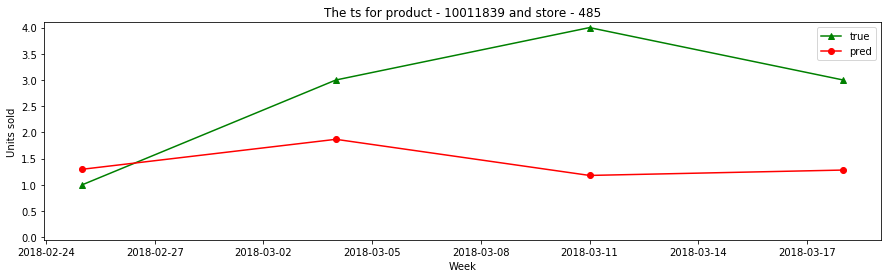

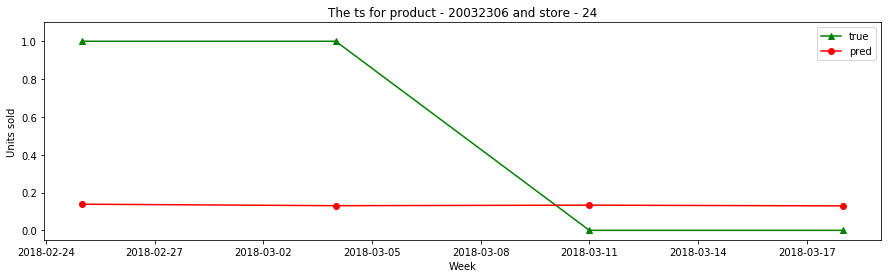

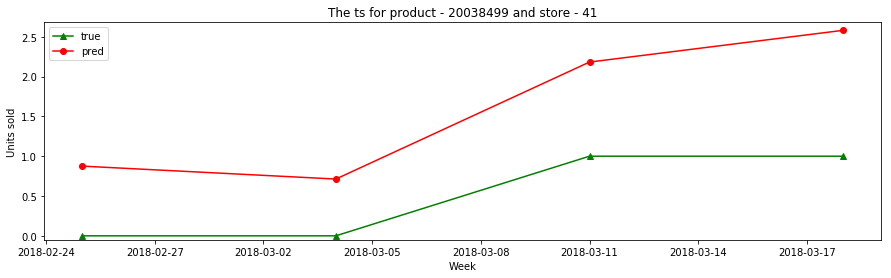

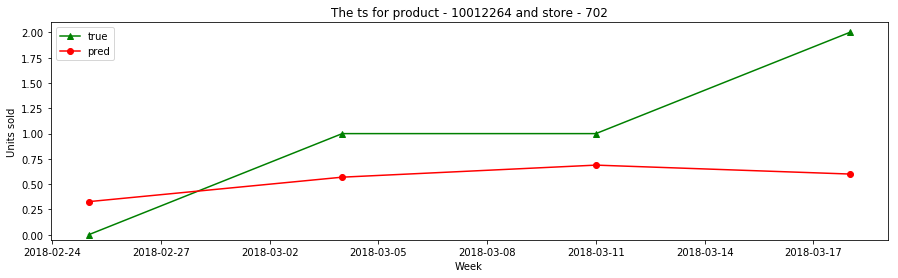

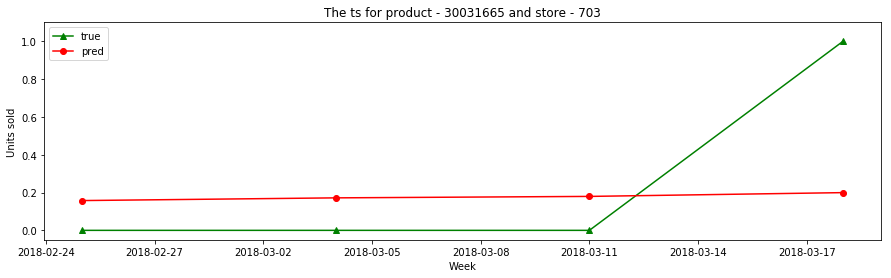

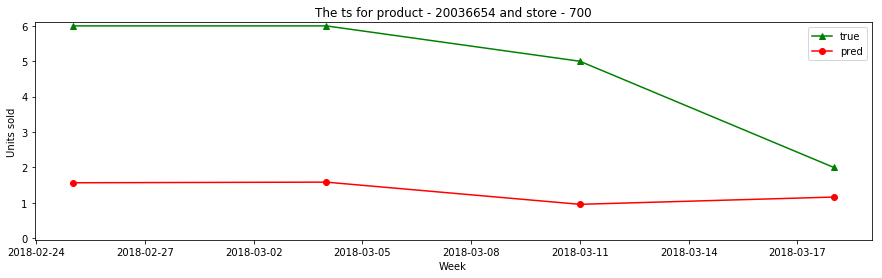

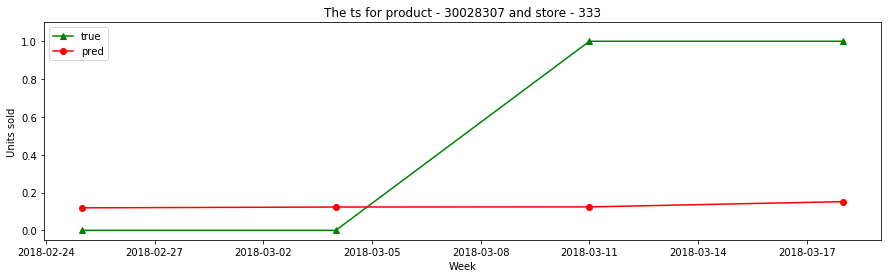

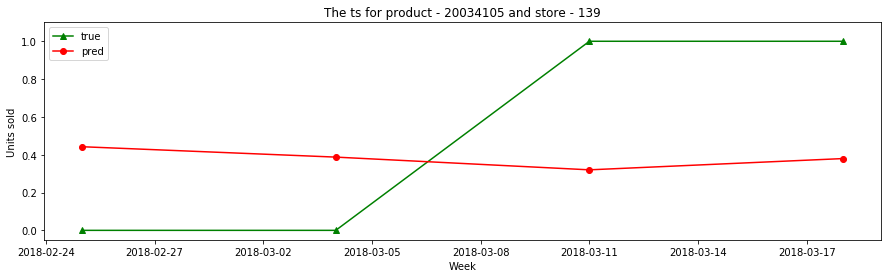

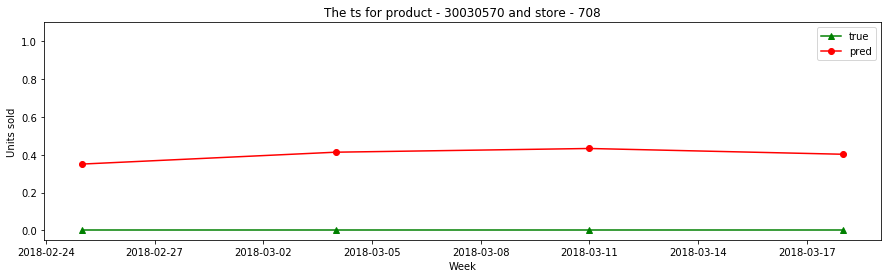

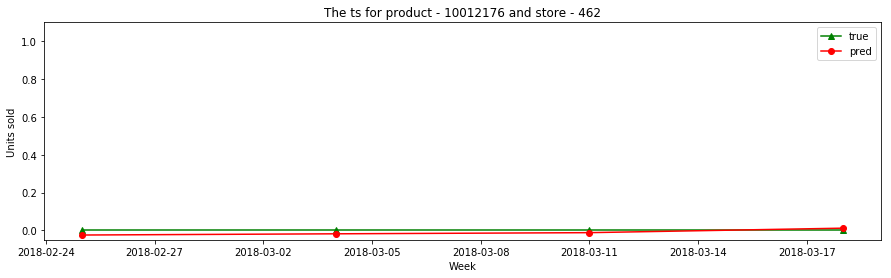

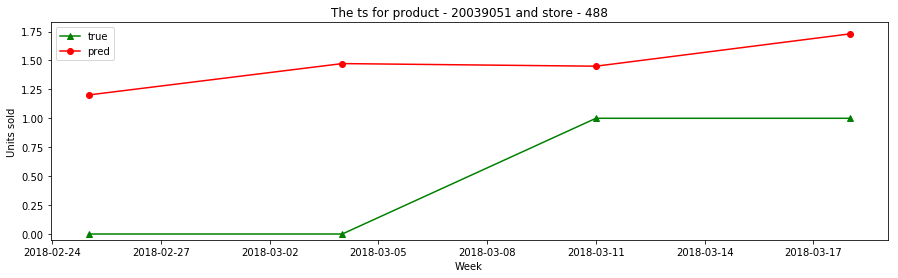

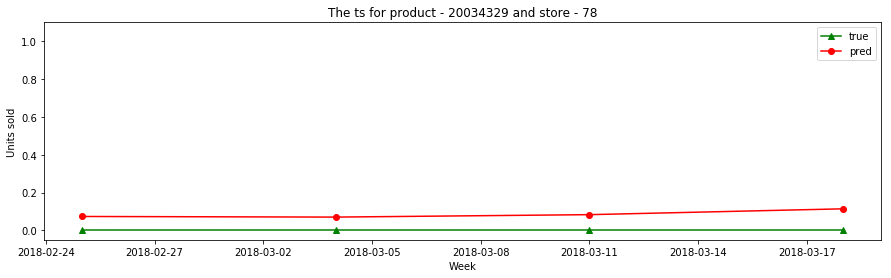

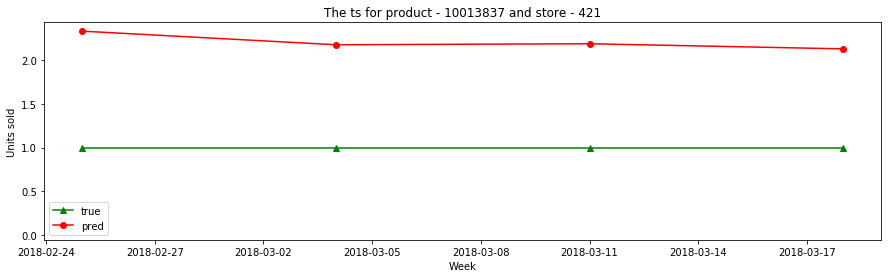

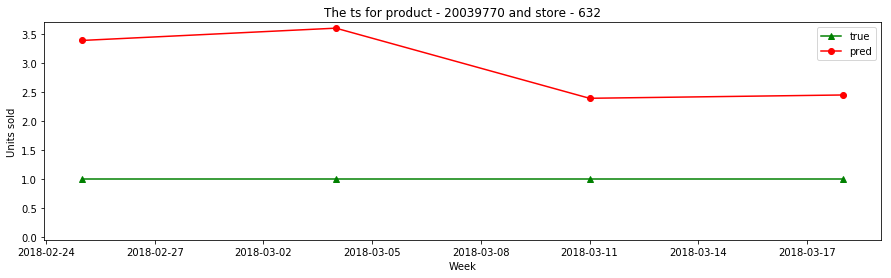

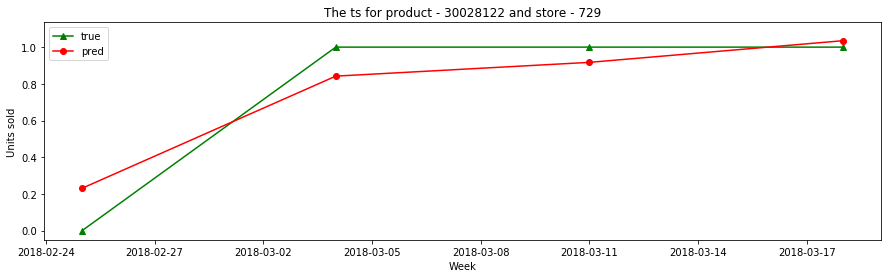

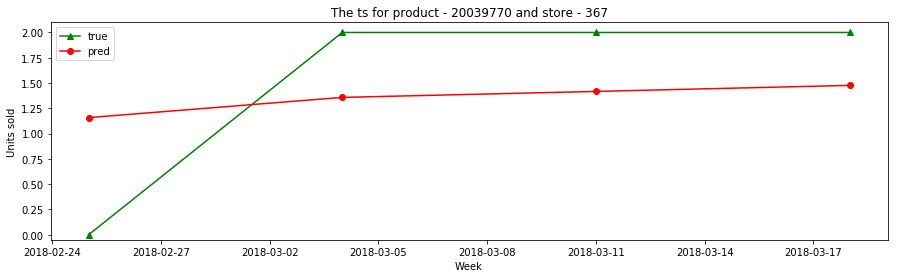

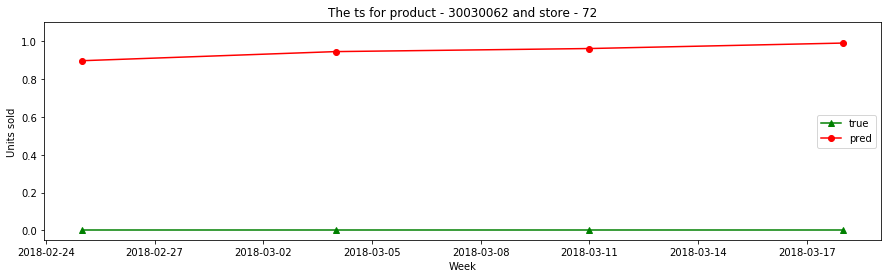

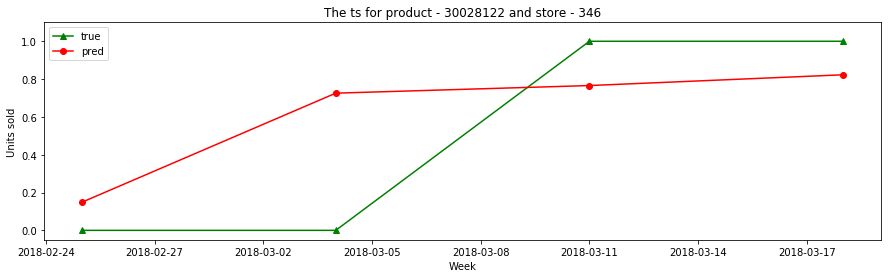

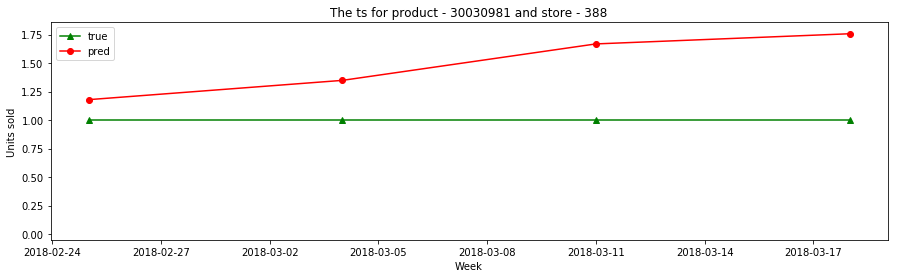

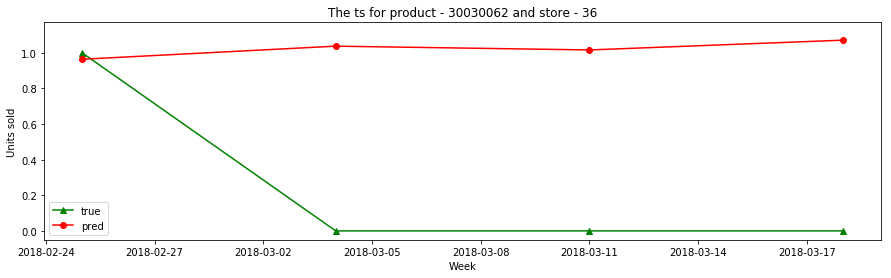

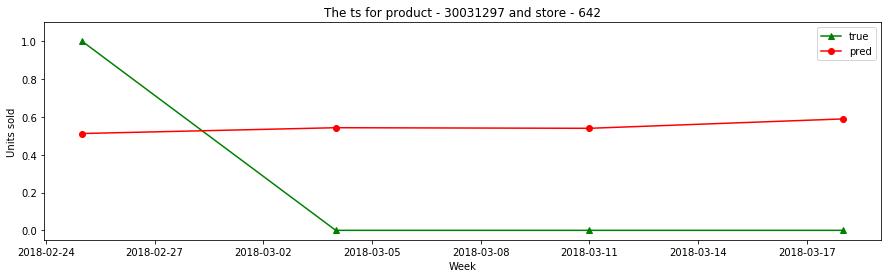

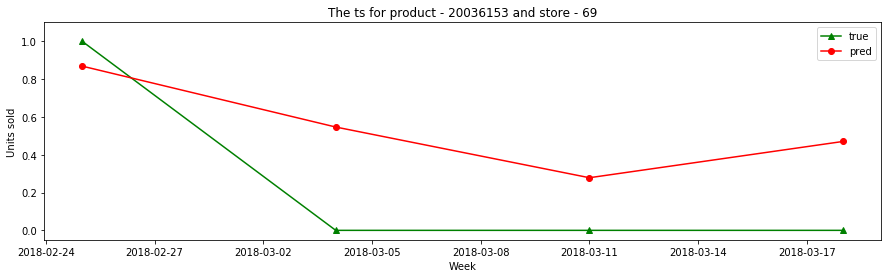

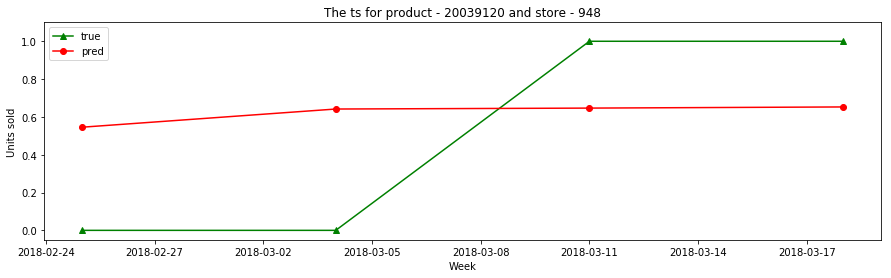

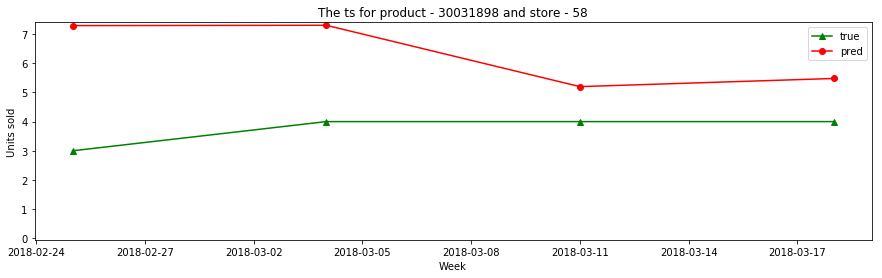

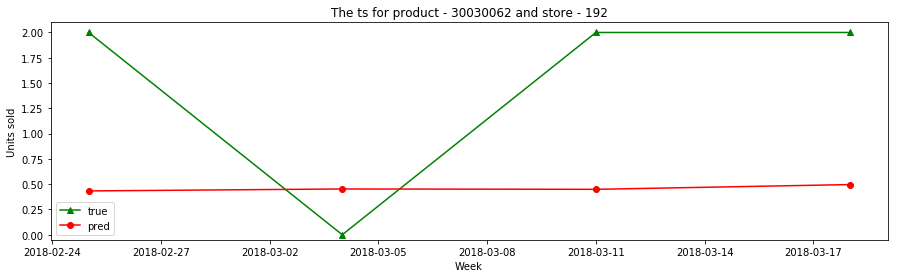

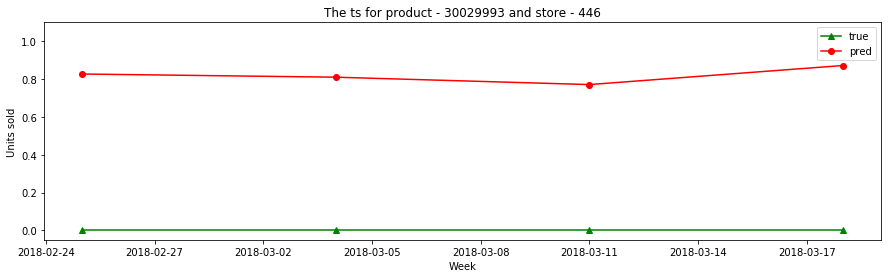

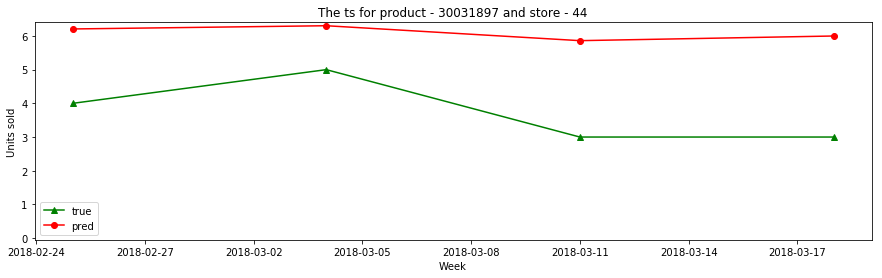

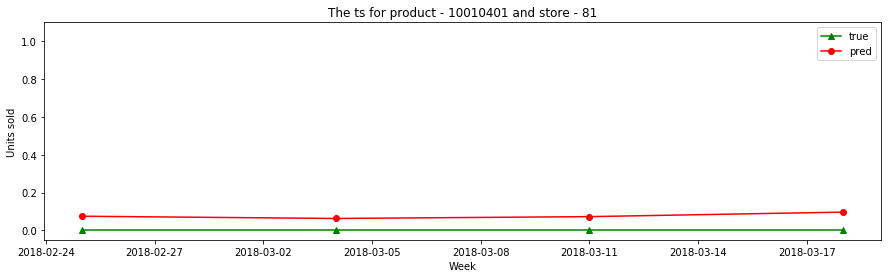

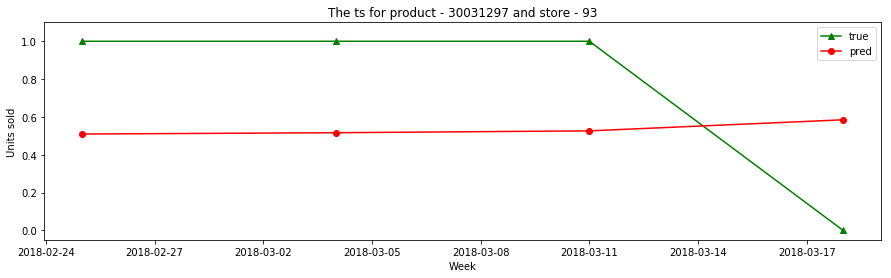

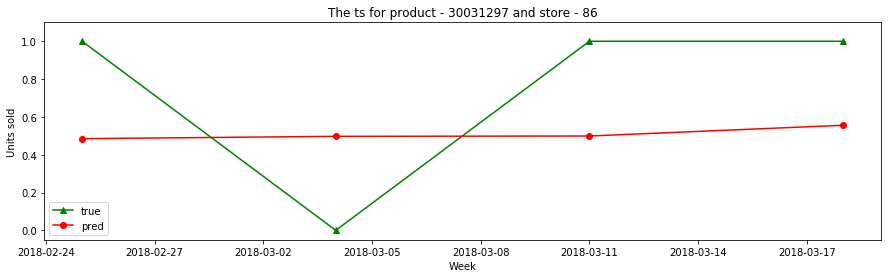

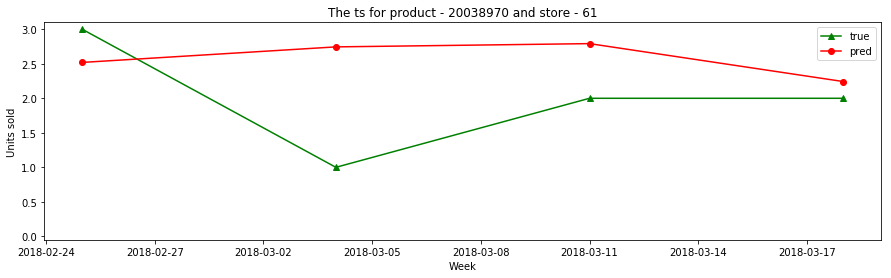

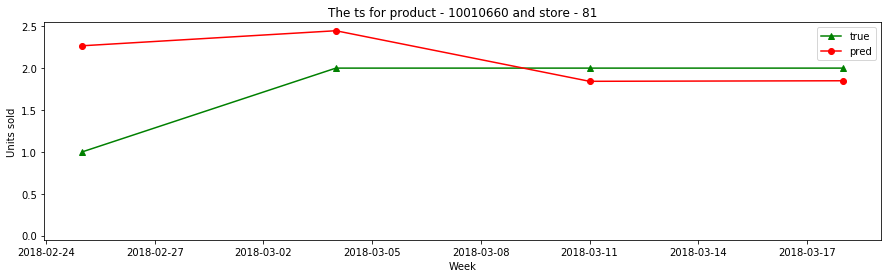

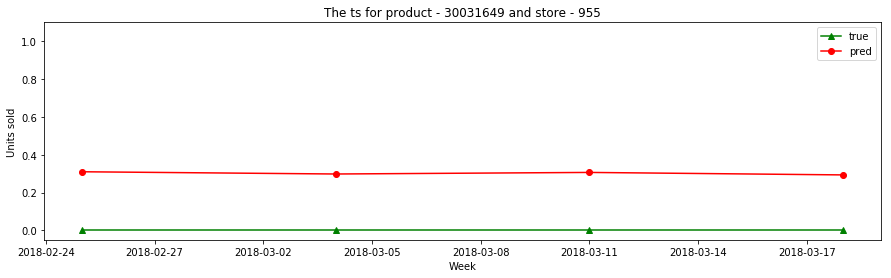

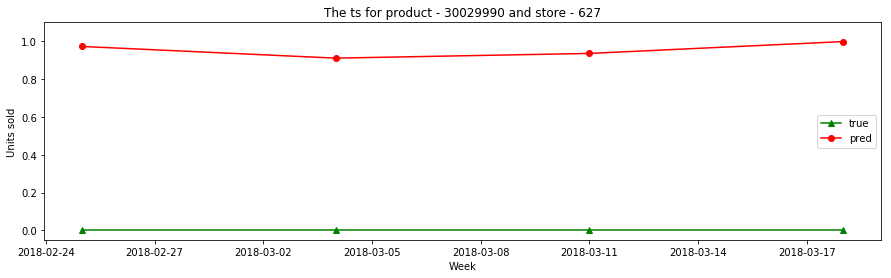

In [32]:
pairs = list(set(zip(res['STORE_ID'], res['PRODUCT_ID'])))

for i in range(len(pairs) // 1000):
    store_id, product_id = pairs[i]
    plot_ts(res, store_id, product_id)

In [33]:
dts2 = lgb.Dataset(data_train2[feat], label = data_train2.UNITS_SOLD_P4)

In [34]:
dts2 = dts2.construct()

In [35]:
bst.current_iteration()

1214

In [36]:
bst2 = lgb.train(params, dts2, num_boost_round = bst.current_iteration())

In [37]:
bst2.save_model('/main/data/MVideo_2/lgb_7_m_4_full.txt')

In [38]:
#bst2 = lgb.Booster(model_file = '/main/data/MVideo_2/lgb_7_m_4_full.txt')

In [39]:
pred2 = bst2.predict(data_test[feat])

In [40]:
res = data_test[['PRODUCT_ID', 'STORE_ID']].copy()

In [41]:
res['PRED'] = pred2

In [42]:
res2 = pd.read_parquet('/main/data/MVideo_2/dataset_test_7.parquet')

In [43]:
res2 = res2[(res2.DATE >= '2018-10-07') & (res2.DATE <= '2018-10-28')].copy()

In [44]:
res2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139160 entries, 417480 to 556639
Data columns (total 3 columns):
STORE_ID      139160 non-null category
PRODUCT_ID    139160 non-null category
DATE          139160 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](1)
memory usage: 2.7 MB


In [45]:
res2 = res2.merge(res)

In [46]:
res2.PRED /= 4

In [47]:
res2.PRED.clip(lower = 0, inplace = True)

In [48]:
res2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139160 entries, 0 to 139159
Data columns (total 4 columns):
STORE_ID      139160 non-null category
PRODUCT_ID    139160 non-null category
DATE          139160 non-null datetime64[ns]
PRED          139160 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 3.8 MB


In [49]:
res2.to_parquet('/main/data/MVideo_2/results_7_m_4_full.parquet')

In [50]:
exp = shap.TreeExplainer(bst2)

In [51]:
shv = exp.shap_values(data_test[feat])

In [52]:
np.save('/main/data/MVideo_2/shv_7_m_4_full.npy', shv)

In [53]:
#shv = np.load('/main/data/MVideo_2/shv_7_m_4_full.npy')

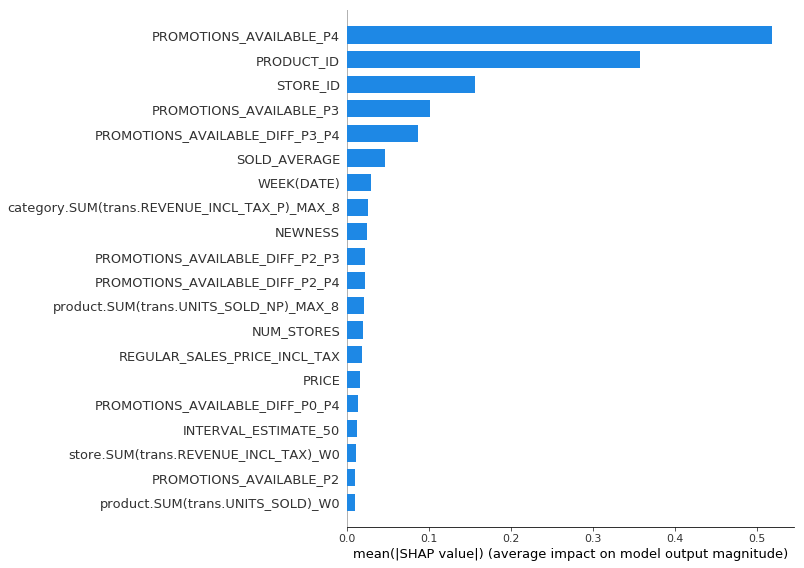

In [54]:
shap.summary_plot(shv, data_test[feat], plot_type = 'bar')

In [55]:
sc = np.mean(np.abs(shv), axis = 0)

In [56]:
score = pd.DataFrame(100 * sc / np.sum(sc),
                     index = bst2.feature_name(), columns = ['Score'])

In [57]:
score = score.sort_values('Score', ascending=False)

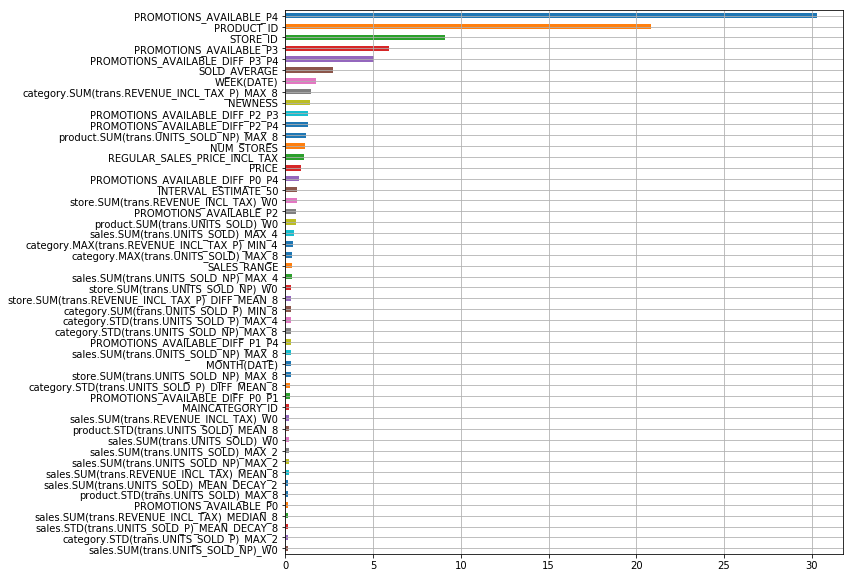

In [58]:
score.head(50).Score.plot.barh(grid=True, figsize=(10,10)).invert_yaxis()